# Master Thesis | Daan de Rijk | 2025

Welcome to the code for my Master Thesis for the track Financial Econometrics. This code produces all the results that are presented in the report, either by means of figures or printed to the output box to go into a table. In order to run this code, some additional files and folders are required. These will be discussed below.

In order to run this code, a folder called "Data" and a folder called "Figures" need to be present in the working directory. The Data folder must contain all the required files in order to run the code, while the Figures folder is used to save the generated figures into. The required files in the Data folder are:
- *returns.csv* - Contains the daily returns from 2013 until 2024 of the 9 initial stocks the research started with;
- *CaViaR_guesses.csv* - Contains the initial guesses for the CaViaR model for the 9 initial stocks. These can also be computed by the search algorithm, but this is very time-consuming. Therefore this is done once, after which these guesses are saved. This can be controlled via the do_gridsearch_CaViaR variable at the start of the Model section;
- *GARCH_guesses.csv* - Contains the initial guesses for the GARCH model for the 9 initial stocks. These can also be computed by the search algorithm, but this is very time-consuming. Therefore this is done once, after which these guesses are saved. This can be controlled via the do_gridsearch_GARCH variable at the start of the Model section;

- *SP100_returns.csv* - Contains the daily returns from 2013 until 2024 of the top 100 stocks from the S&P500 index based on market capitalization;
- *CaViaR_guesses_SP100.csv* - Contains the initial guesses of the CaViaR model for all sample windows that are used during the research for all 100 stocks that are used. The same applies as stated above for the 9 stocks;
- *GARCH_guesses_SP100.csv* - Contains the initial guesses of the GARCH model for all sample windows that are used during the research for all 100 stocks that are used. The same applies as stated above for the 9 stocks;
- *Filtered_VaR_dict.npy* - Contains the full dictionary of dynamic VaR estimates for all sample windows for the 100 stocks of the S&P500. Computing this is very resource-intensive, therefore it has been saved to be used every time. This can be toggled in cell 66, almost at the bottom.

The code needs approximately 3 hours to run completely, assuming the initial guesses and dynamic VaR are already computed and saved into files as described above. The code has been commented and each function has a textbox above it explaining what it does and what it takes in. 

## Prepare the environment

In [1]:
# Load the important packages.
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.regression.quantile_regression import QuantReg
from scipy.stats import chi2, t, genpareto, jarque_bera

import warnings
warnings.filterwarnings('ignore')

# Use a seed to reproduce random things, such as FHS.
global_seed = 1563424213

KeyboardInterrupt: 

## Read the data

In [ ]:
# Read the raw returns, downloaded from WRDS and set formats.
raw_data = pd.read_csv("Data/returns.csv")
raw_data["RET"] = (pd.to_numeric(raw_data["RET"], errors="coerce") * 100)
raw_data["date"] = pd.to_datetime(raw_data["date"], format="%d/%m/%Y")

# Put every stock in its own column.
full_returns = raw_data.pivot(index="date", columns="TICKER", values="RET").reset_index()

# Since META had different tickers over time, combine them.
full_returns["META"] = full_returns["META"].combine_first(full_returns["METV"])
full_returns["META"] = full_returns["META"].combine_first(full_returns["FB"])
full_returns = full_returns.drop(columns=["METV", "FB"])

# Define the training dataframe and the full dataframe.
# Full dataframe also includes data used for backtesting.
training_df = full_returns[full_returns["date"] < "2021-01-01"]
returns = full_returns[full_returns["date"] < "2025-01-01"]

# Print the summary statistics.
stocks = ["AAPL", "AMZN", "AVGO", "JPM", "META", "MSFT", "NVDA", "TSLA", "V"]
returns[stocks].describe().round(5)

TICKER        AAPL        AMZN        AVGO         JPM        META  \
count   3020.00000  3020.00000  3020.00000  3020.00000  3020.00000   
mean       0.10628     0.11543     0.17823     0.08058     0.13177   
std        1.76102     2.03429     2.29432     1.64356     2.32682   
min      -12.86470   -14.04940   -19.91290   -14.96490   -24.55710   
25%       -0.72885    -0.86212    -0.99145    -0.69585    -0.95190   
50%        0.09790     0.10500     0.14510     0.06805     0.10735   
75%        1.01575     1.15912     1.29355     0.85128     1.24048   
max       11.98080    14.13110    24.43260    18.01250    29.60770   

TICKER        MSFT        NVDA        TSLA           V  
count   3020.00000  3020.00000  3020.00000  3020.00000  
mean       0.11211     0.24469     0.23690     0.08442  
std        1.66082     2.85944     3.62024     1.50747  
min      -14.73900   -18.75590   -21.06280   -13.54720  
25%       -0.66092    -1.12620    -1.56420    -0.64690  
50%        0.09080     0.21370     0.14285     0.13405  
75%        0.94985     1.58812     1.92740     0.83238  
max       14.21690    29.80670    24.40290    13.84260

## Plot the time series

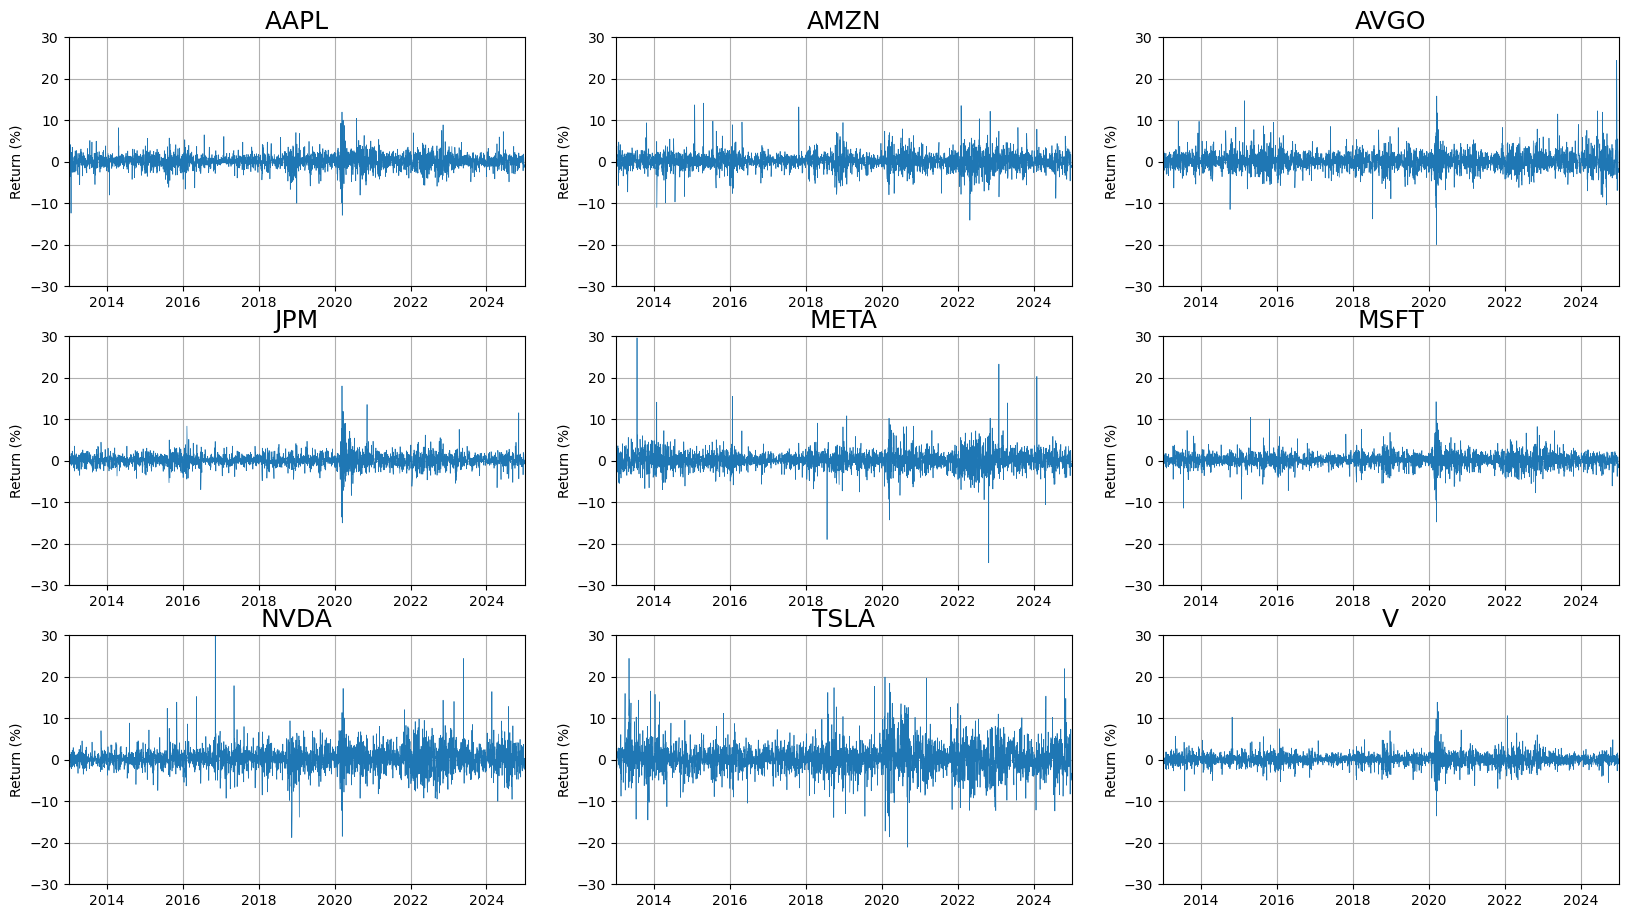

In [ ]:
# Define the start and end date of the figure.
start_date = pd.to_datetime("2013-01-01")
end_date = pd.to_datetime("2025-01-01")

# Set figure size.
plt.figure(figsize=(20, 11))

# Make a plot of all time series.
for index, stock in enumerate(stocks):
    plt.subplot(3, 3, index + 1)
    plt.plot(returns["date"], returns[stock], linewidth=0.5)
    plt.xlim(start_date, end_date)
    plt.ylim(-30, 30)
    plt.ylabel("Return (%)")
    plt.title(stock, fontsize=18)
    plt.grid()

plt.savefig("Figures/time_series.png", bbox_inches='tight', facecolor='w', dpi = 300)

## Models

### General variables

In [ ]:
# Define some general variables.
quantile = 0.05
data = training_df

# Define the dataframe of initial guesses, which can be used to save computation time.
do_gridsearch_GARCH = False
do_gridsearch_CaViaR = False
GARCH_guesses = pd.read_csv("Data/GARCH_guesses.csv")
CaViaR_guesses = pd.read_csv("Data/CaViaR_guesses.csv")

### GJR-GARCH(1,1) with Student-t distribution

In [ ]:
"""
GARCH_filter 
Takes in the values for theta of the GJR-GARCH(1,1) with a student-t distribution and the return data,
then it computes the filtered variance (sig2).

llik_GJR
Takes in the values for theta of the GJR-GARCH with a student-t distribution and the return data,
then it computes the value of the mean log-likelihood. This function is used to obtain the parameter
vector using Maximum Likelihood.

ML
Takes in the return data and the initial guesses for the model and computes the parameters of the 
GJR-GARCH(1,1) using an optimizer. Returns the obtained parameters and the convergence success.

grid_seach_GARCH
Takes in the return data and computes the log-likelihood using "llik_GJR" of many different combinations 
of the parameter vector. These are then used to feed into the optimizer, or are saved into a .csv file.
Since this function is very time comsuming, it has been run once and after that these guesses are saved.
For each stock, this search takes approximately 25 seconds and depends on the size of the dataset.
"""


# Function for the GARCH filter.
def GARCH_filter(theta, data):

    # Change to array for computational efficiency and extract parameter vector.
    data = np.asarray(data)
    T = len(data)
    omega, alpha, beta, gamma, nu = theta

    # Initialize sigma^2 at its unconditional variance.
    sig2 = np.zeros(T)
    sig2[0] = np.var(data)

    # Define the GJR-GARCH indicator function (1 if return < 0, 0 else).
    GJR_ind = (data < 0).astype(int)

    # Loop through each time t to filter.
    for t in range(0, T-1):
        sig2[t+1] = omega + alpha*(data[t]**2) + beta*sig2[t] + gamma*(data[t]**2)*GJR_ind[t]   

    return sig2


# Log-likelihood function for the GJR-GARCH model with Student's t-distribution.
def llik_GJR(theta, data): 

    # Define the length of the time series and extract initial parameters.
    T = len(data)
    omega, alpha, beta, gamma, nu = theta
    
    # Run the GARCH filter by calling the function.
    sig2 = GARCH_filter(theta, data)
    
    # Calculate the log-likelihood. From Lennarts guides Case Study.
    ll = math.lgamma((nu+1)/2) - math.lgamma(nu/2) - 0.5*np.log((nu-2)*np.pi*sig2) \
        - 0.5*(nu+1)*np.log(1+(data**2)/((nu-2)*sig2))

    return -np.mean(ll)


# Function to estimate GJR-GARCH parameters by ML.
def ML(data, theta_ini):

    # Define the bounds.
    theta_bounds = [(0, 10), (0, 1), (0, 1), (-1, 1), (2, 50)]

    # Run the optimization.
    results = minimize(llik_GJR, theta_ini, args=(data), method='SLSQP', bounds=theta_bounds)

    return results.x, results.success


# Grid search algorithm to obtain the best initial guess for the GARCH.
def grid_search_GARCH(data):

    # Initialize the lowest LL very high.
    min_LL = 1000

    # Loop through all possible ranges of the parameters to obtain best guess.
    for omega in np.arange(0, 1, 0.2):
        for alpha in np.arange(0, 0.1, 0.02):
            for beta in np.arange(0.4, 1, 0.05):
                for gamma in np.arange(0, 0.4, 0.05):
                    for nu in np.arange(2, 10, 1):
                        theta = [omega, alpha, beta, gamma, nu]
                        LL = llik_GJR(theta, data)
                        
                        # If current guess is better than lowest, save it.
                        if LL < min_LL:
                            min_LL = LL
                            theta_guess = theta

    # Return the best guess for that time series.
    return theta_guess 

In [ ]:
"""
full_GARCH
Function that takes in the full dataset, the training dataset, the relevant stocks, the initial guesses
so that it doesn't compute it each time and if it prints the summary of convergence of each stock.
It calculates the parameters for each stock, after which it computes the filtered GARCH and the VaR.
It returns the filtered GARCH of each stock in a single dataframe, the VaR based on the Student-t
distribution and a list of stocks that did converge. Stocks that haven't converged are dropped from the
function, since they are unusable. 
"""

# Function to compute the full GARCH based on the given parameters.
def full_GARCH(full_data, training_data, stocks, GARCH_guesses, printing=True):

    # Initialize storage and parameters.
    T = len(stocks)
    GARCH_params = pd.DataFrame(np.nan, index=range(T), columns=["stock", "omega", "alpha", "beta", "gamma", "nu"])
    initial_guesses = pd.DataFrame(np.nan, index=range(T), columns=["stock", "omega", "alpha", "beta", "gamma", "nu"])
    filtered_GARCH = pd.DataFrame()
    VaR_GARCH = pd.DataFrame()
    converged_stocks = []

    # Loop through all the stocks to calculate their parameters.
    for index, stock in enumerate(stocks):

        # Call grid search algorithm to find the best starting value.
        if do_gridsearch_GARCH:
            theta_ini = grid_search_GARCH(training_data[stock])
            initial_guesses.iloc[index] = [stock] + list(theta_ini)

        # If not, use stored starting values of corresponding stock from the csv.
        else:
            theta_ini = GARCH_guesses.loc[GARCH_guesses["stock"] == stock].iloc[0, 1:]

        # Run the ML estimation to obtain the parameters.
        params, converged = ML(training_data[stock], theta_ini)

        # If stock converged, store the parameters. Only print when asked for.
        if converged:
            GARCH_params.iloc[index] = [stock] + list(params)
            converged_stocks.append(stock)

            if printing:
                print(f"Convergence: {converged} - {stock}") # | {list(theta_ini)}")
            
        # When not converged, discard this stock.
        else:
            if printing:
                print(f"Convergence: {converged} - {stock} | Excluded")

    # # Save the grid search initial guesses to a csv.
    # initial_guesses.to_csv("Data/GARCH_guesses_SP100_"+str(year)+".csv", index=False)

    # Reset the indices of GARCH_params, otherwise next loop fails because of unalignment.
    GARCH_params = GARCH_params.dropna().reset_index(drop=True)

    # Filter the converged GARCH models.
    for index, stock in enumerate(converged_stocks):

        # Extract the variables of interest to put into filter function.
        theta = list(GARCH_params.loc[index][1:6])

        # Determine the critical value using inverse cdf of Student-t.
        nu = theta[4]
        GARCH_crit = t.ppf(quantile, df=nu)

        # Run the filter and calculate the volatility based on GJR-GARCH(1,1). 
        sig2 = GARCH_filter(theta, full_data[stock])
        filtered_GARCH[stock] = np.sqrt(sig2)
        VaR_GARCH[stock] = GARCH_crit*filtered_GARCH[stock]

    # Print GARCH params when asked for.
    if printing:
        print()
        print(GARCH_params)

    return filtered_GARCH, VaR_GARCH, converged_stocks

Parameters for in-sample GJR-GARCH:
Convergence: True - AAPL
Convergence: True - AMZN
Convergence: True - AVGO
Convergence: True - JPM
Convergence: True - META
Convergence: True - MSFT
Convergence: True - NVDA
Convergence: True - TSLA
Convergence: True - V

  stock     omega     alpha      beta     gamma        nu
0  AAPL  0.151076  0.025504  0.844905  0.204169  4.323131
1  AMZN  0.297935  0.045154  0.780937  0.258924  3.989958
2  AVGO  0.294433  0.018918  0.841319  0.169270  4.970333
3   JPM  0.095727  0.021333  0.850588  0.208319  4.995757
4  META  0.042029  0.016647  0.938604  0.085675  3.990818
5  MSFT  0.142851  0.053756  0.809194  0.236316  4.003948
6  NVDA  0.152700  0.023895  0.902160  0.139901  3.662545
7  TSLA  0.127280  0.032968  0.956796  0.012076  3.362344
8     V  0.136548  0.022194  0.788903  0.296926  5.000244


Parameters for out-of-sample GJR-GARCH:
Convergence: True - AAPL
Convergence: True - AMZN
Convergence: True - AVGO
Convergence: True - JPM
Convergence: True - M

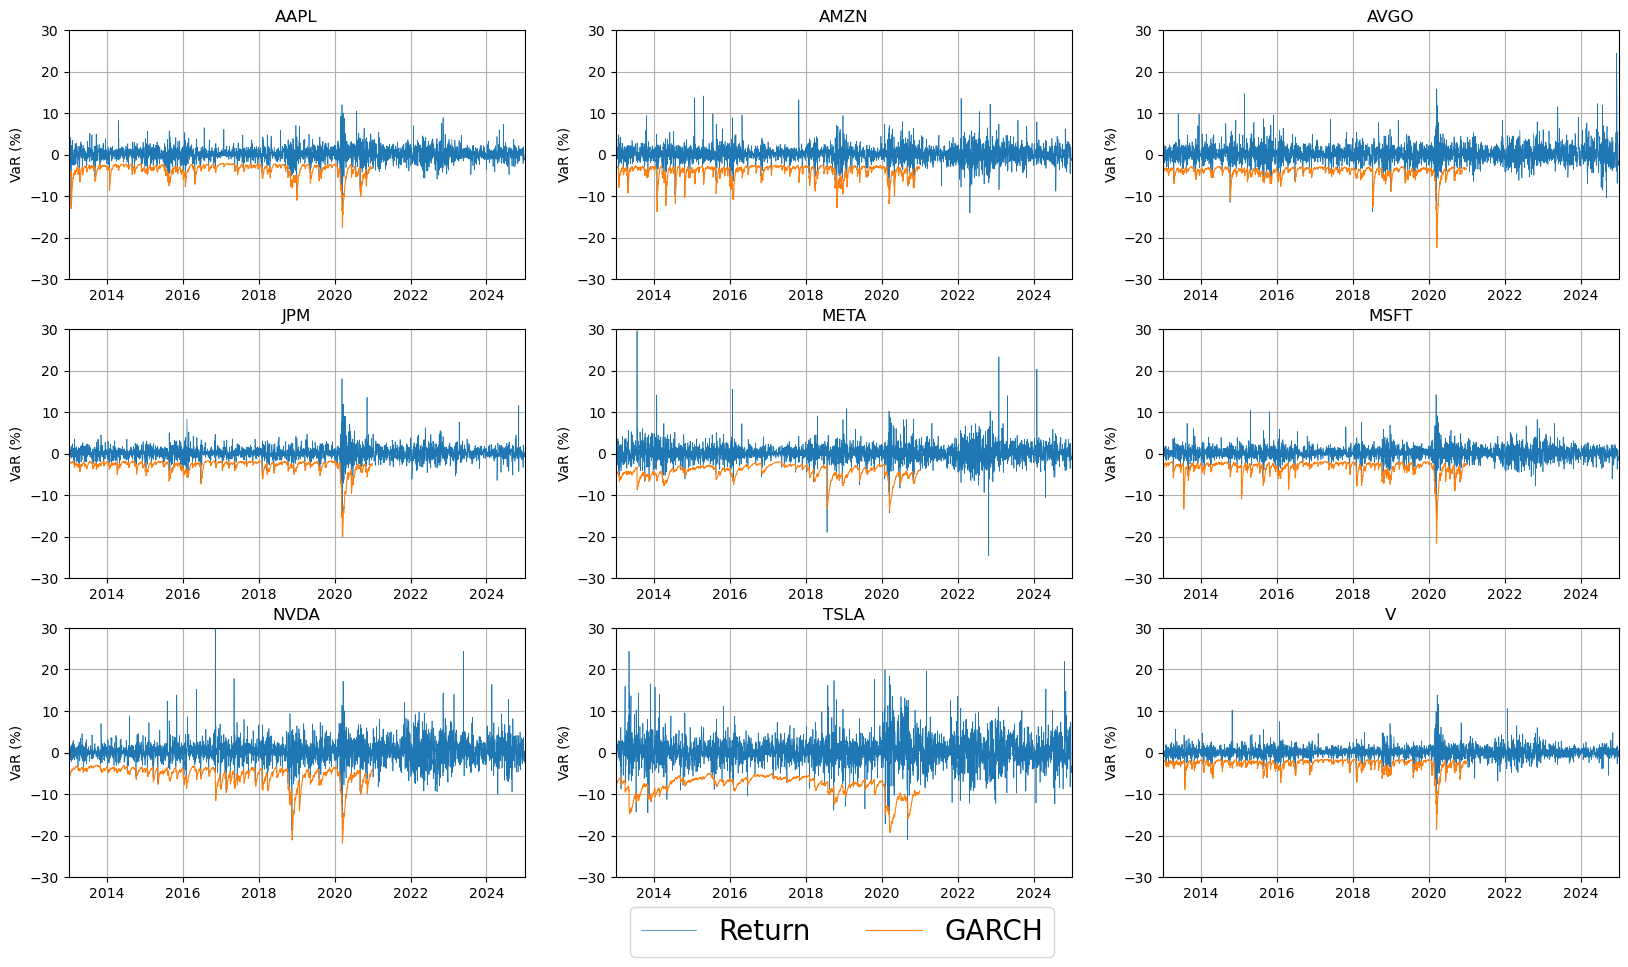

In [ ]:
# Run the above function to obtain IS and OOS GJR-GARCH(1,1) filters.
print("Parameters for in-sample GJR-GARCH:")
is_filtered_GARCH, is_VaR_GARCH, converged_stocks = full_GARCH(training_df, training_df, stocks, GARCH_guesses)
print("\n\nParameters for out-of-sample GJR-GARCH:")
oos_filtered_GARCH, oos_VaR_GARCH, converged_stocks = full_GARCH(returns, training_df, stocks, GARCH_guesses)

# Set figure size.
plt.figure(figsize=(20, 11))

# Make a plot of all time series.
for index, stock in enumerate(stocks):
    plt.subplot(3, 3, index + 1)
    plt.plot(returns["date"], returns[stock], linewidth=0.5, label="Return")
    plt.plot(data["date"], is_VaR_GARCH[stock], linewidth=0.8, label="GARCH")
    plt.xlim(start_date, end_date)
    plt.ylim(-30, 30)
    # plt.xlabel("Date")
    plt.ylabel("VaR (%)")
    plt.title(stock)
    plt.grid()

plt.legend(fontsize=20, loc='center left', bbox_to_anchor=(-1.2, -0.22), ncol=2)

### Filtered Historical Simulation (FHS)

In [ ]:
"""
full_FHS
Takes in the return data, the relevant stocks, the in-sample filtered GARCH and out-of-sample filtered 
GARCH in order to obtain the FHS estimate of the VaR. This is done by normalizing the stock returns using
the volatility of the GARCH model, drawing a random sample and then obtaining the current value of the 
VaR. It returns the in-sample and out-of-sample filtered FHS VaR estimates.
"""

# Function for the FHS.
def full_FHS(data, stocks, is_filtered_GARCH, oos_filtered_GARCH):

    # Set seed so the results can be re-generated. 
    np.random.seed(global_seed)
    
    # Define the lengths T and a dataframe to store FHS values into.
    T_is = len(data)
    T_oos = len(oos_filtered_GARCH)
    oos_FHS = pd.DataFrame()

    # Loop through all stocks.
    for stock in stocks:

        # First obtain the standardized returns and a list for the VaR.
        standardized_returns = data[stock] / is_filtered_GARCH[stock]
        VaR = np.zeros(T_oos)  
        
        # Loop through all the timesteps.
        for t in range(T_oos):
        
            # Draw T samples from standardized returns as done in Abad et al (p.8).
            draw = np.random.choice(standardized_returns, size=T_oos)

            # Using this sample, obtain the scaled volatility and the VaR.
            scaled_volatility = draw * oos_filtered_GARCH[stock].iloc[t]
            VaR[t] = np.quantile(scaled_volatility, quantile)

        # Store the VaR values into the dataframe.
        oos_FHS[stock] = VaR
    
    # Define the in-sample based on the out-of-sample.
    is_FHS = oos_FHS[:T_is]
    
    return is_FHS, oos_FHS

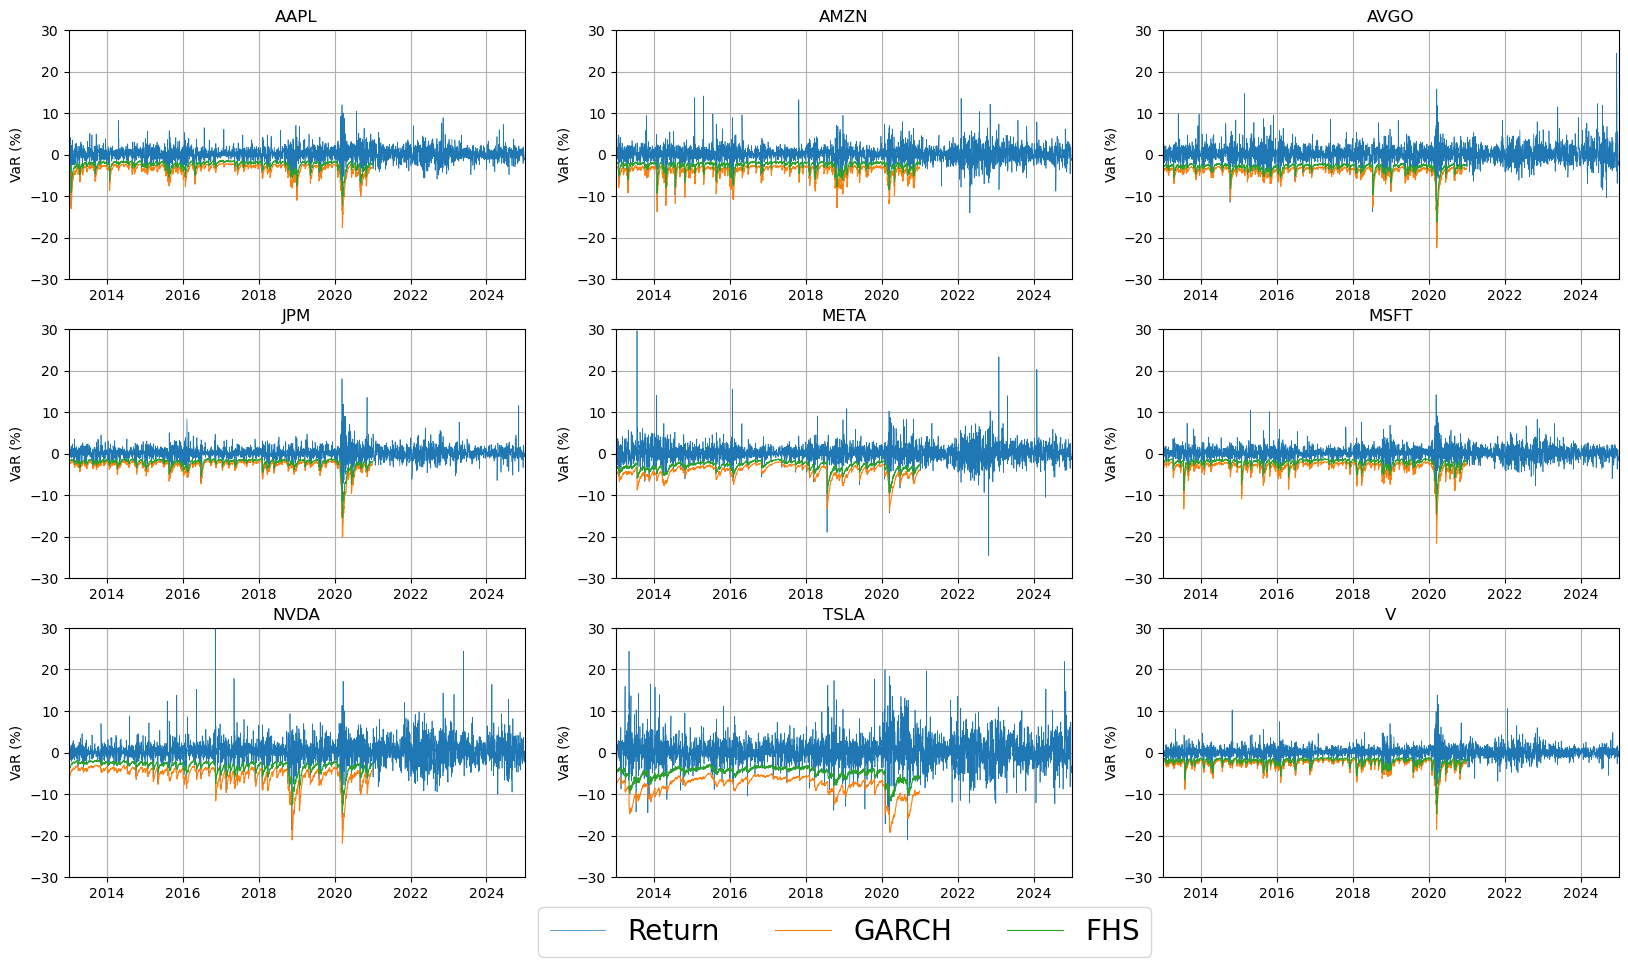

In [ ]:
# Obtain the VaR from the FHS function.
is_FHS, oos_FHS = full_FHS(training_df, converged_stocks, is_filtered_GARCH, oos_filtered_GARCH)

# Set figure size.
plt.figure(figsize=(20, 11))

# Make a plot of all 5 time series.
for index, stock in enumerate(stocks):
    plt.subplot(3, 3, index + 1)
    plt.plot(returns["date"], returns[stock], linewidth=0.5, label="Return")
    plt.plot(data["date"], is_VaR_GARCH[stock], linewidth=0.8, label="GARCH")
    plt.plot(data["date"], is_FHS[stock], linewidth=0.8, label="FHS")
    plt.xlim(start_date, end_date)
    plt.ylim(-30, 30)
    # plt.xlabel("Date")
    plt.ylabel("VaR (%)")
    plt.title(stock)
    plt.grid()

plt.legend(fontsize=20, loc='center left', bbox_to_anchor=(-1.4, -0.22), ncol=3)

### Asymmetric Slope CaViaR

In [ ]:
"""
CaViaR_filter
Takes in the parameter vector of the Asymmetric Slope CaViaR, the return data and the value of the quantile (0.05).
It then computes the VaR based on the formula in the original paper and returns the filtered VaR.

loss_CaViaR
Takes in the parameter vector, the return data and the value of the quantile. Then computes the loss in order to 
optimize the parameters, based on Engle&Manganelli. Returns the final loss, which can be used in to optimize.

grid_search_CaViaR
Takes in the data and the value of the quantile in order to look for the best initial guess for the CaViaR
optimization. CaViaR is very sensitive to the initial guess, so this is very important! Again, these guesses
are saved to a .csv such that they do not have to be computed each time. Returns the best guess for the initial 
vector. This takes approximately 1 minute per stock, depending on the size of the dataset.

minimize_CaViaR
Takes in the return data, the value of the quantile and the initial value of the parameter vector. It then uses
a minimizer to obtain the lowest value for the loss, indicating the best fit. The resulting parameter vector and
success of optimization are returned. 
"""

# Function to filter the CaViaR model.
def CaViaR_filter(theta, data, alpha):

    # Define the length of the time series and extract initial parameters.
    data = np.asarray(data)
    T = len(data)
    beta1, beta2, beta3, beta4 = theta

    # Initialize VaR at its alpha quantile value.
    VaR = np.zeros(T)
    VaR[0] = np.quantile(data, alpha)

    # Define the indicator function.
    neg_returns = (data < 0).astype(int)
    pos_returns = (data > 0).astype(int)

    # Loop through each time t. Based on Asymmetric Slope from original paper (p4 left).
    for t in range(0,T-1):
        VaR[t+1] = beta1 + beta2*VaR[t] + beta3*pos_returns[t]*data[t] + beta4*neg_returns[t]*data[t]

    return VaR


# Function to calculate the CaViaR loss to optimize.
def loss_CaViaR(theta, data, alpha): 
    
    # Run the CaViaR filter.
    VaR = CaViaR_filter(theta, data, alpha)
    
    # Calculate the loss to optimize the parameters, according to Engle&Manganelli.
    ind_fun = (data < VaR).astype(int)
    loss = np.mean((alpha - ind_fun)*(data - VaR))

    return loss


# Grid search algorithm to obtain the best initial guess for the CaViaR.
def grid_seach_CaViaR(data, alpha):

    # Initialize the lowest loss very high.
    min_loss = 1000

    # Loop through all possible ranges of the beta's to obtain best guess.
    for beta1 in np.arange(-1, 0.5, 0.1):
        for beta2 in np.arange(0.4, 0.99, 0.02):
            for beta3 in np.arange(-0.5, 0.5, 0.1):
                for beta4 in np.arange(0, 1, 0.1):
                    theta = [beta1, beta2, beta3, beta4]
                    loss_value = loss_CaViaR(theta, data, alpha)
                    
                    # If current guess is better than lowest, save it.
                    if loss_value < min_loss:
                        min_loss = loss_value
                        theta_guess = theta

    # Return the best guess for that time series.
    return theta_guess 


# Function to estimate the CaViaR parameters.
def minimize_CaViaR(data, alpha, theta_ini):

    # Define the bounds.
    theta_bounds = [(-2, 2), (0, 1), (-1, 1), (-1, 1)]

    # Run the optimization and return the parameters.
    results = minimize(loss_CaViaR, theta_ini, args=(data, alpha), method="SLSQP", bounds=theta_bounds)

    return results.x, results.success

In [ ]:
"""
full_CaViaR
Takes in the full return data, the training data, the relevant stocks and the initial guesses. It then obtains
the parameter vector with the lowest loss and uses that to filter the VaR based on the given return data. It 
returns the filtered CaViaR from the function.
"""

# Full function to obtain the CaViaR filters and parameters.
def full_CaViaR(full_data, training_data, stocks, guesses, year):
    
    # Define a dataframe to put the parameters into.
    CaViaR_params = pd.DataFrame(np.nan, index=range(len(stocks)), columns=["stock", "beta1", "beta2", "beta3", "beta4"])
    initial_guesses = pd.DataFrame(np.nan, index=range(len(stocks)), columns=["stock", "beta1", "beta2", "beta3", "beta4"])

    # Loop through all the stocks to calculate their parameters.
    for index, stock in enumerate(stocks):

        # Call grid search algorithm to find a suitable starting value.
        if do_gridsearch_CaViaR:
            theta_ini = grid_seach_CaViaR(training_data[stock], quantile)
            initial_guesses.iloc[index] = [stock] + list(theta_ini)

        # When initial guesses are available, use that.
        else:        
            theta_ini = guesses.loc[guesses["stock"] == stock].iloc[0, 1:]

        # Run the ML estimation and append parameters to the dataframe.
        params, converged = minimize_CaViaR(training_data[stock], quantile, theta_ini)
        CaViaR_params.iloc[index] = [stock] + list(params)
        print(f"Convergence: {converged} - {stock}") # | {list(theta_ini)}")

    # # Save the grid search initial guesses to a csv.
    # initial_guesses.to_csv("Data/CaViaR_guesses_SP100_"+str(year)+".csv", index=False)

    # Filter the CaViaR
    filtered_CaViaR = pd.DataFrame()

    # Filter the CaViaR for each stock.
    for index, stock in enumerate(stocks):

        # Extract the variables of interest to put into filter function.
        theta = list(CaViaR_params.loc[index][1:5])

        # Run the filter and calculate the volatility. 
        VaR = CaViaR_filter(theta, full_data[stock], quantile)
        filtered_CaViaR[stock] = VaR

    # Print CaViaR params.
    print()
    print(CaViaR_params)
    
    return filtered_CaViaR

Parameters for in-sample CaViaR:
Convergence: True - AAPL
Convergence: True - AMZN
Convergence: True - AVGO
Convergence: True - JPM
Convergence: True - META
Convergence: True - MSFT
Convergence: True - NVDA
Convergence: True - TSLA
Convergence: True - V

  stock     beta1     beta2     beta3     beta4
0  AAPL -0.144020  0.830901 -0.117485  0.358452
1  AMZN -0.269195  0.707636 -0.246732  0.563633
2  AVGO -0.383373  0.703982 -0.293769  0.422187
3   JPM -0.210925  0.770181 -0.098991  0.496098
4  META -0.171920  0.823070 -0.147232  0.362644
5  MSFT -0.136591  0.735978 -0.385441  0.505608
6  NVDA -0.084694  0.882631 -0.122264  0.272632
7  TSLA -0.152130  0.902137 -0.073358  0.212102
8     V -0.169273  0.822230 -0.049055  0.384305


Parameters for out-of-sample CaViaR:
Convergence: True - AAPL
Convergence: True - AMZN
Convergence: True - AVGO
Convergence: True - JPM
Convergence: True - META
Convergence: True - MSFT
Convergence: True - NVDA
Convergence: True - TSLA
Convergence: True - V

  st

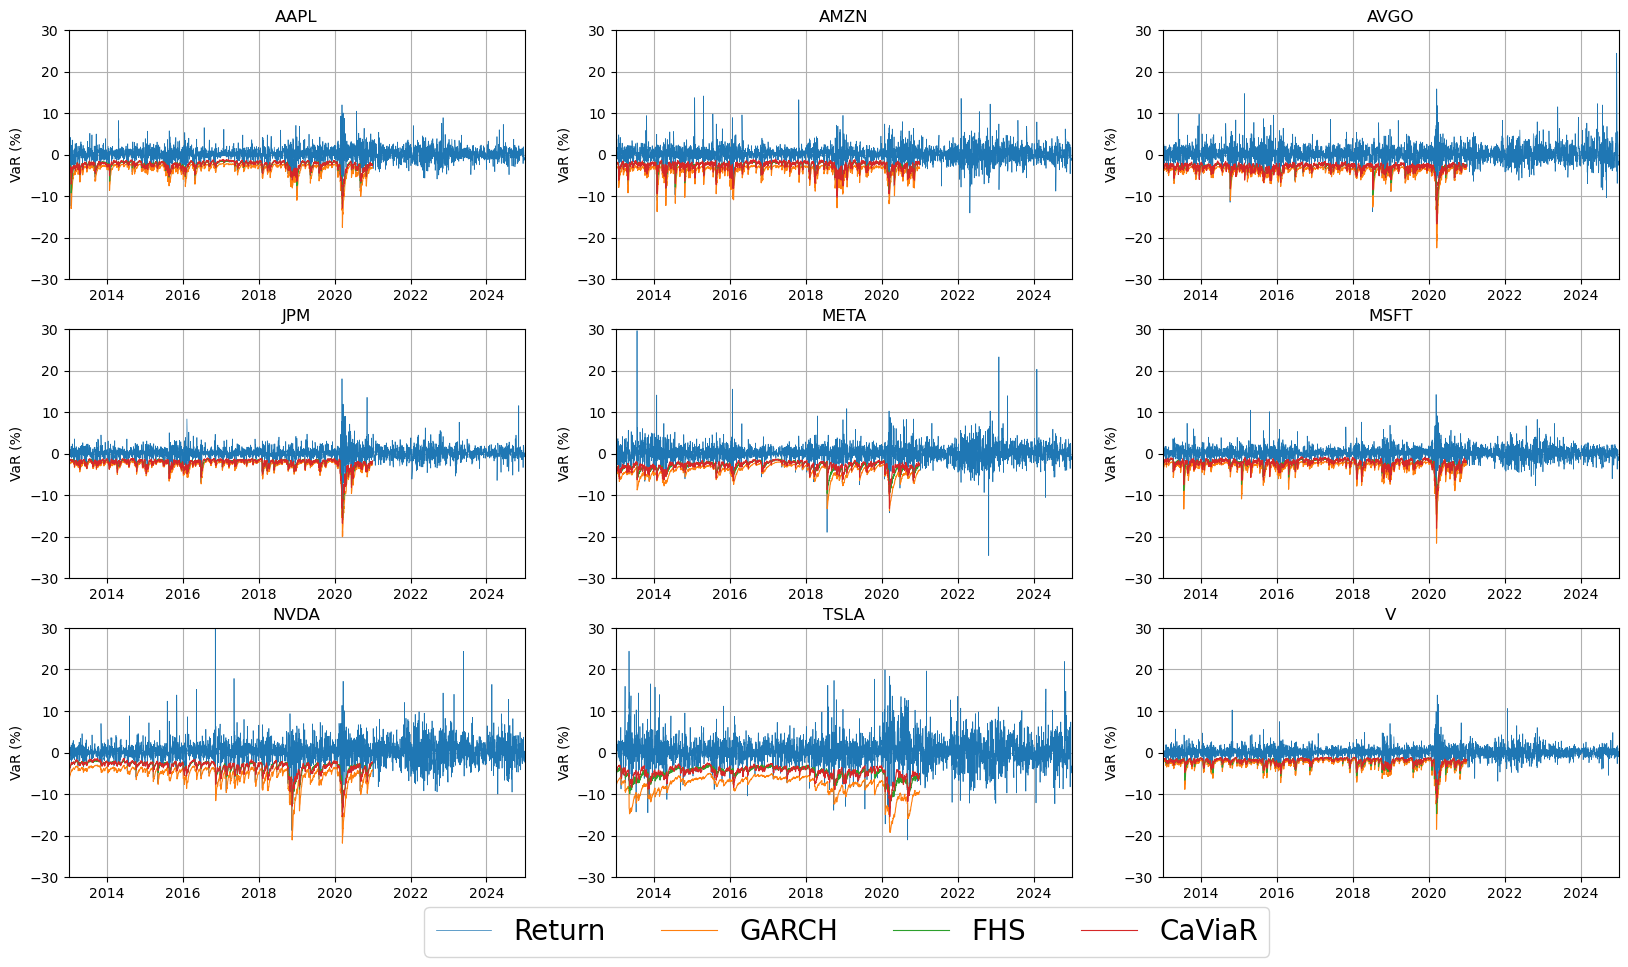

In [ ]:
print("Parameters for in-sample CaViaR:")
is_filtered_CaViaR = full_CaViaR(training_df, training_df, stocks, CaViaR_guesses, 2019)
print("\n\nParameters for out-of-sample CaViaR:")
oos_filtered_CaViaR = full_CaViaR(returns, training_df, stocks, CaViaR_guesses, 2019)

# Set figure size.
plt.figure(figsize=(20, 11))

# Make a plot of all time series.
for index, stock in enumerate(stocks):
    plt.subplot(3, 3, index + 1)
    plt.plot(returns["date"], returns[stock], linewidth=0.5, label="Return")
    plt.plot(data["date"], is_VaR_GARCH[stock], linewidth=0.8, label="GARCH")
    plt.plot(data["date"], is_FHS[stock], linewidth=0.8, label="FHS")
    plt.plot(data["date"], is_filtered_CaViaR[stock], linewidth=0.8, label="CaViaR")
    plt.xlim(start_date, end_date)
    plt.ylim(-30, 30)
    # plt.xlabel("Date")
    plt.ylabel("VaR (%)")
    plt.title(stock)
    plt.grid()

plt.legend(fontsize=20, loc='center left', bbox_to_anchor=(-1.65, -0.22), ncol=4)

### CoVaR

In [ ]:
"""
full_CoVaR
Takes in the full return data, the training data, the relevant stocks and which underlying VaR approach
is used (CaViaR, GARCH or FHS). Then it computes the CoVaR based on the quantile regression. It returns
the full filtered CoVaR of all the combinations of stocks, which is the number of stocks squared.
"""

# Define a function for the CoVaR.
def full_CoVaR(full_data, training_data, stocks, VaR_type):
    
    # Define global variables.
    T = len(full_data)
    filtered_CoVaR = pd.DataFrame()

    # Loop through all stocks to calculate their CoVaR based the other stocks.
    for stock1 in stocks:
        
        # Loop through this list a second time to capture all combinations (n^2).
        for stock2 in stocks:
            
            # Run the QuantReg regression to obtain dependencies.
            const = sm.add_constant(training_data[stock2])
            model = QuantReg(training_data[stock1], const).fit(q=quantile)

            # Define the arrays to save CoVaRs into.
            CoVaR_distress = np.zeros(T)

            # Obtain the CoVaR value for each time t.
            for t in range(T):
                CoVaR_distress[t] = model.predict([1, VaR_type[stock2][t]])

            # Save this into the dataframe.
            name = str(stock1) + "|" + str(stock2)
            filtered_CoVaR[name] = CoVaR_distress

    return filtered_CoVaR

In [ ]:
# Run the CoVaR function.
print("Running for in-sample CoVaR...")
is_filtered_CoVaR = full_CoVaR(training_df, training_df, stocks, is_filtered_CaViaR)
print("Running for out-of-sample CoVaR...\n")
oos_filtered_CoVaR = full_CoVaR(returns, training_df, stocks, oos_filtered_CaViaR)

# Define the length of the out-of-sample period.
T = len(returns) - len(training_df)

# Calculate the VR.
for stock in stocks:
    
    # Print the violation ratio. Seems to overestimate risk, since VR<<1.
    # This is logical since we are looking conditional on another stock in distress.
    # Most of the time this is not the case, so it overestimates the risk.
    remaining_stocks = [item for item in stocks if stock != item]
    for stock2 in stocks:
        name = str(stock) + "|" + str(stock2)
        
        # Calculate the VR.
        VR = np.sum((returns[stock] < oos_filtered_CoVaR[name])[-T:])/(quantile*T)
        print(f"VR for {stock}|{stock2} is {VR}.")

    print()

Running for in-sample CoVaR...
Running for out-of-sample CoVaR...

VR for AAPL|AAPL is 1.1741293532338308.
VR for AAPL|AMZN is 0.417910447761194.
VR for AAPL|AVGO is 0.3582089552238806.
VR for AAPL|JPM is 0.5174129353233831.
VR for AAPL|META is 0.3781094527363184.
VR for AAPL|MSFT is 0.29850746268656714.
VR for AAPL|NVDA is 0.3383084577114428.
VR for AAPL|TSLA is 0.5572139303482587.
VR for AAPL|V is 0.3781094527363184.

VR for AMZN|AAPL is 0.8756218905472637.
VR for AMZN|AMZN is 1.3333333333333333.
VR for AMZN|AVGO is 0.736318407960199.
VR for AMZN|JPM is 0.8955223880597015.
VR for AMZN|META is 0.6965174129353234.
VR for AMZN|MSFT is 0.7761194029850746.
VR for AMZN|NVDA is 0.736318407960199.
VR for AMZN|TSLA is 0.7164179104477612.
VR for AMZN|V is 0.7562189054726368.

VR for AVGO|AAPL is 0.4975124378109453.
VR for AVGO|AMZN is 0.6965174129353234.
VR for AVGO|AVGO is 1.1940298507462686.
VR for AVGO|JPM is 0.6368159203980099.
VR for AVGO|META is 0.5771144278606966.
VR for AVGO|MSFT is 0.

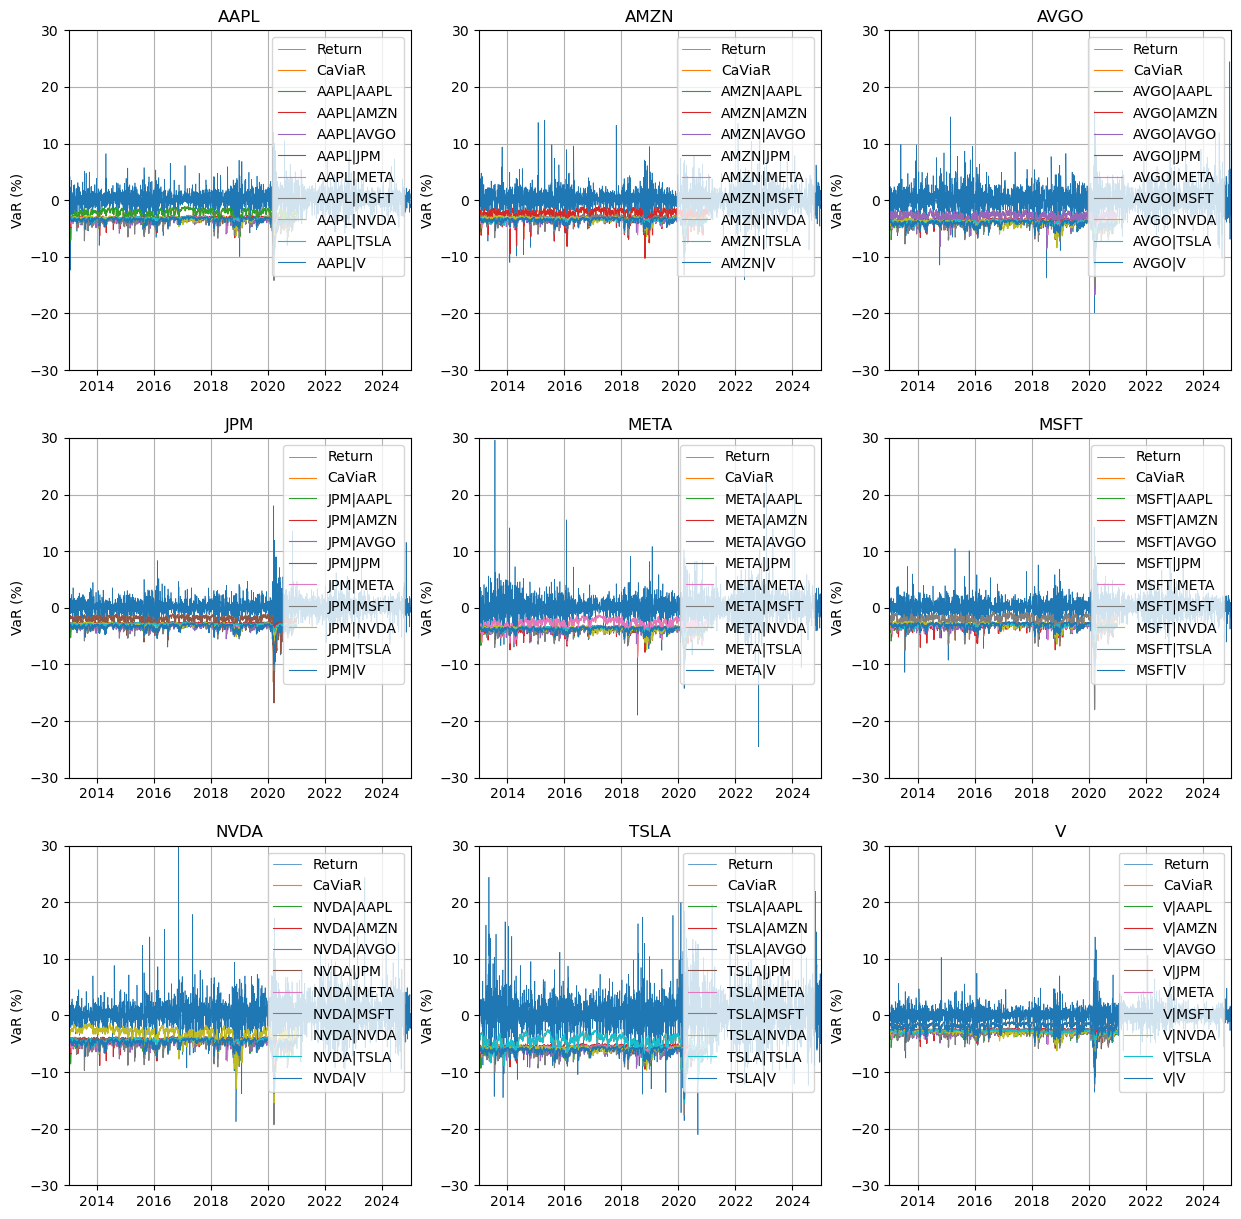

In [ ]:
# Make a plot of all time series and their 5% VaR.
plt.figure(figsize=(15, 15))

# Write a for-loop to make it easier.
for index, stock in enumerate(stocks):
    matching_columns = [col for col in is_filtered_CoVaR.columns if stock + "|" in col]

    plt.subplot(3, 3, index+1)
    plt.plot(returns["date"], returns[stock], linewidth=0.5, label="Return")
    plt.plot(data["date"], is_filtered_CaViaR[stock], linewidth=0.8, label="CaViaR")
    plt.plot(data["date"], is_filtered_CoVaR[matching_columns], linewidth=0.8, label=matching_columns)
    plt.xlim(start_date, end_date)
    plt.ylim(-30, 30)
    # plt.xlabel("Date")
    plt.ylabel("VaR (%)")
    plt.title(stock)
    plt.grid()
    plt.legend(loc="upper right")

### Peak Over Threshold (POT)

In [ ]:
"""
rolling_POT
Takes in the training data and the corresponding confidence level. Uses these data to compute the
exceedances and fit a Generalized Pareto distribution. These parameters can then be used to obtain
the value for the VaR, which is returned.

full_POT

"""

# Function to compute the VaR using POT. Abad et al p10.
def rolling_POT(training_data, confidence_level):

    # First define the threshold, the exceedances and the empirical probability.
    u = np.quantile(training_data, confidence_level)
    exceedances = training_data[training_data < u] - u
    pu = len(exceedances) / len(training_data)

    # Run the fit to obtain the parameters of the tail distribution.
    alpha, _, beta = genpareto.fit(-exceedances, floc=0)

    # Calculate the VaR and return it.
    VaR = u + (beta / alpha) * (((1 - pu) / (1 - confidence_level)) ** alpha - 1)

    return VaR


# 
def full_POT(full_data, training_data, stocks):
    
    # Filter the CaViaR
    is_filtered_POT = pd.DataFrame()
    oos_filtered_POT = pd.DataFrame()
    T = len(full_data) - len(training_data)

    for stock in stocks:
        POT_VaR = rolling_POT(training_data[stock], quantile)
        is_filtered_POT[stock] = [POT_VaR] * len(training_data)
        oos_filtered_POT[stock] = [POT_VaR] * T
    
    return is_filtered_POT, oos_filtered_POT

Running for out-of-sample POT...



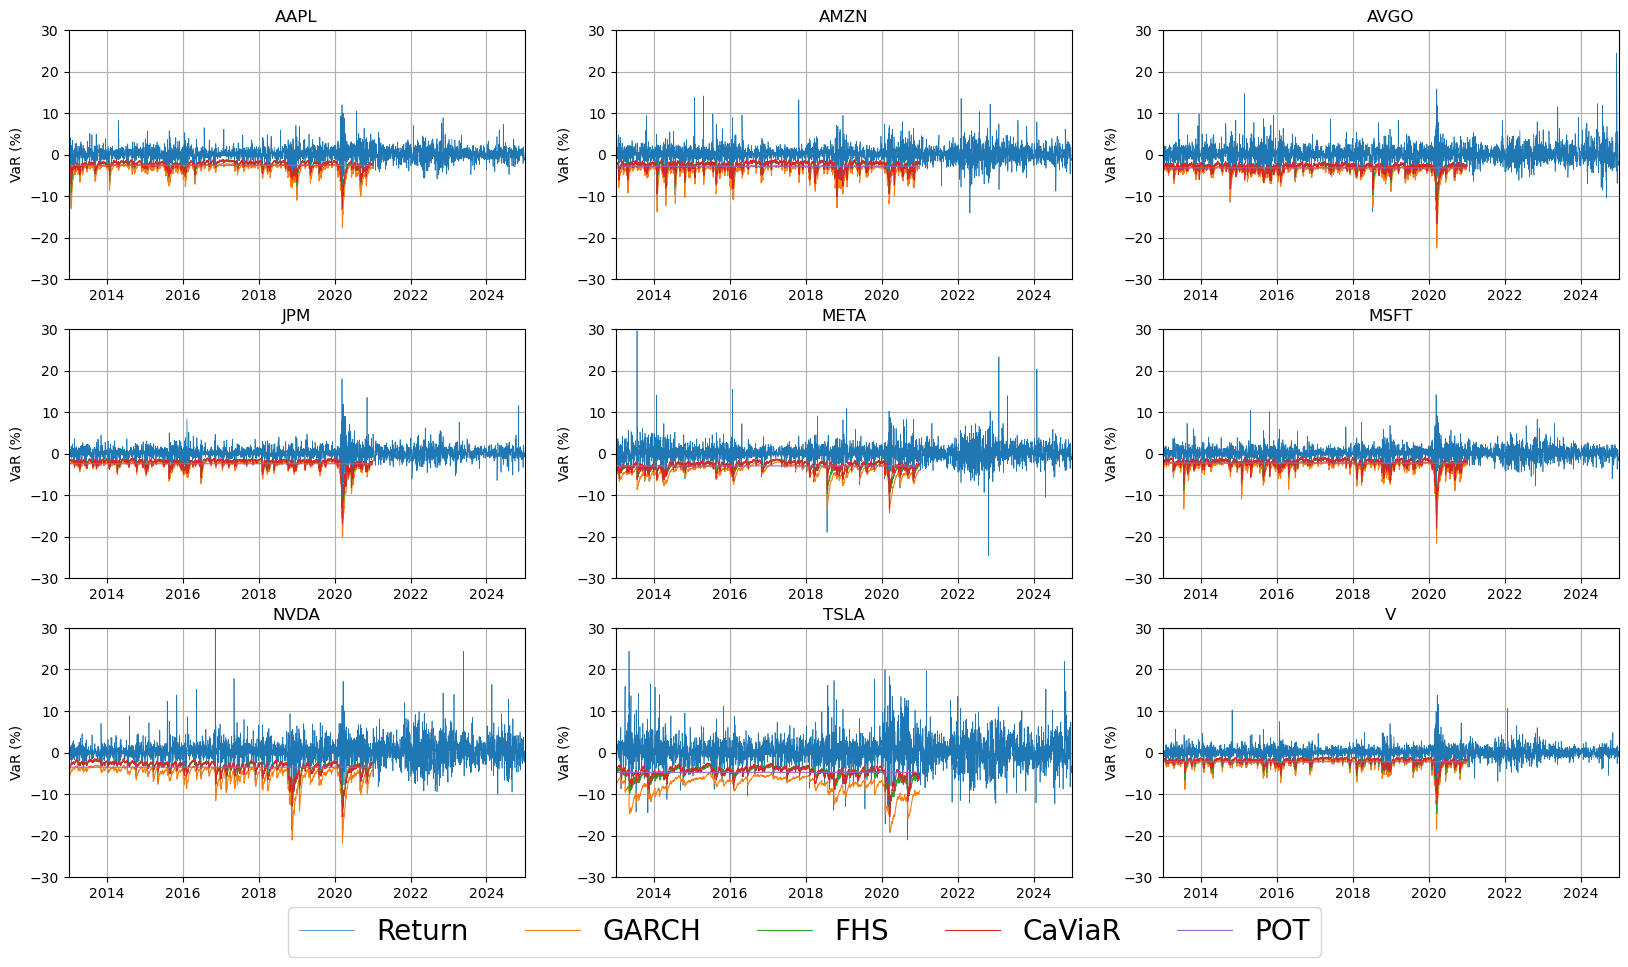

In [ ]:
# 
print("Running for out-of-sample POT...\n")
is_filtered_POT, oos_filtered_POT = full_POT(returns, training_df, stocks)

# Set figure size.
plt.figure(figsize=(20, 11))

# Make a plot of all time series.
for index, stock in enumerate(stocks):
    plt.subplot(3, 3, index + 1)
    plt.plot(returns["date"], returns[stock], linewidth=0.5, label="Return")
    plt.plot(data["date"], is_VaR_GARCH[stock], linewidth=0.8, label="GARCH")
    plt.plot(data["date"], is_FHS[stock], linewidth=0.8, label="FHS")
    plt.plot(data["date"], is_filtered_CaViaR[stock], linewidth=0.8, label="CaViaR")
    plt.plot(data["date"], is_filtered_POT[stock], linewidth=0.8, label="POT")
    plt.xlim(start_date, end_date)
    plt.ylim(-30, 30)
    # plt.xlabel("Date")
    plt.ylabel("VaR (%)")
    plt.title(stock)
    plt.grid()

plt.legend(fontsize=20, loc='center left', bbox_to_anchor=(-1.95, -0.22), ncol=5)

## Backtesting

### Static

In [ ]:
"""
christoffersen_backtest
Takes in the a list of violations and the value of the quantile. Then it computes the unconditional coverage
test, the independence test and the joint conditional coverage test. It then returns a dictionary of the 
t-statistics and the p-values that correspond to the inputted data, or the output in form of a LaTeX table
such that it can be copied to the report directly. This can be switched by commenting the right return. 

run_christoffersen
Takes in a dataframe of violations, with each column containing a stock and each row either a 1 or a 0 based
on if a violation has happened. Then runs the christoffersen_backtest for every stock and prints the result.
"""

# Function to implement the Christoffersen Backtesting procedure as in Abad et al p11.
def christoffersen_backtest(violations, alpha=quantile):

    # --- Unconditional Coverage Test ---
    n = len(violations)
    x = np.sum(violations)
    alpha_hat = x / n
    VR = x/round(alpha*n)

    # Test of equation 30, follows a chi^1(1) distribution.
    first_term = alpha_hat**x * (1 - alpha_hat)**(n-x)
    second_term = alpha**x * (1 - alpha)**(n-x)
    LR_uc = 2 * (np.log(first_term) - np.log(second_term))
    pval_uc = 1 - chi2.cdf(LR_uc, df=1)


    # --- Independence Test ---
    N00 = N01 = N10 = N11 = 0
    
    # Calculate n00, n01, n10, n11 according to footnote 10.
    for t in range(1, n):
        
        # "N_ij denotes the number of observations in state j after 
        # having been in state i in the previous period".
        prev = violations[t-1]
        curr = violations[t]
        if prev == 0 and curr == 0:
            N00 += 1
        elif prev == 0 and curr == 1:
            N01 += 1
        elif prev == 1 and curr == 0:
            N10 += 1
        elif prev == 1 and curr == 1:
            N11 += 1

    # Define the values for pi
    pi01 = N01/(N00 + N01)
    pi11 = N11/(N10 + N11)
    pi = (N11 + N01)/n

    # Calculate the likelihood ratio, prevent negative LR value.
    L0 = (1-pi)**(N00+N01) * pi**(N01+N11)
    LA = (1-pi01)**N00 * (pi01**N01) * (1-pi11)**N10 * pi11**N11
    LR_ind = max(0, 2 * (np.log(LA) - np.log(L0)))
    pval_ind = 1 - chi2.cdf(LR_ind, df=1)


    # --- Joint Conditional Coverage Test ---
    LR_cc = LR_uc + LR_ind
    pval_cc = 1 - chi2.cdf(LR_cc, df=2)

    # Return the results as a dictionary.
    # return {'Unconditional Coverage': (LR_uc, pval_uc),
    #         'Independence': (LR_ind, pval_ind),
    #         'Conditional Coverage': (LR_cc, pval_cc),
    #         'Violations': x,
    #         'VR': VR}

    # Or return the results as LaTeX format.
    # If the value is below 0.05, return it as boldface for the table.
    if pval_uc < 0.05:
        string_uc = f"\\textbf{{{pval_uc:.3f}}}"
    else:
        string_uc = f"{pval_uc:.3f}"

    # If the value is below 0.05, return it as boldface for the table.
    if pval_ind < 0.05:
        string_ind = f"\\textbf{{{pval_ind:.3f}}}"
    else:
        string_ind = f"{pval_ind:.3f}"

    # If the value is below 0.05, return it as boldface for the table.
    if pval_cc < 0.05:
        string_cc = f"\\textbf{{{pval_cc:.3f}}}"
    else:
        string_cc = f"{pval_cc:.3f}"

    # Return for the table, for regular use use the other return statement above.
    return f"{string_uc} & {string_ind} & {string_cc} & {VR:.3f}\\\\"

# Function to run the Christoffersen test for all stocks and all VaR approaches.
def run_christoffersen(violations, quantile):
    for stock in violations.columns:
        print(f"& \\textbf{{{stock}}} &", christoffersen_backtest(np.array(violations[stock]), quantile))

In [ ]:
"""
check_violations
Takes in the VaR, the returns and an empty dataframe and checks every moment in time for a violation in the VaR.
It a violation takes place, it places a 1 there in the dataframe. Returns a dataframe of zeros and ones.This can 
then be fed into the christoffersen function to calculate the coverage and independence tests.
"""

# Function to check violations.
def check_violations(VaR, returns, violation_df):
    
    # Check for each stock the violations, a 1 means a violation has occured.
    for stock in VaR.columns:
        main_stock = stock.split("|")[0]        # To cope with AAPL|AAPL ot V|V from CoVaR.
        violation_df[stock] = (returns[main_stock].values < VaR[stock].values).astype(int)

    # Return dataframe.
    return violation_df

# Save the dataframes of each VaR approach. These can be thrown into the Christoffersen test.
violation_GARCH = check_violations(oos_VaR_GARCH[-T:], returns[-T:], pd.DataFrame())
violation_FHS = check_violations(oos_FHS[-T:], returns[-T:], pd.DataFrame())
violation_CaViaR = check_violations(oos_filtered_CaViaR[-T:], returns[-T:], pd.DataFrame())
violation_POT = check_violations(oos_filtered_POT[-T:], returns[-T:], pd.DataFrame())
violation_CoVaR = check_violations(oos_filtered_CoVaR[-T:], returns[-T:], pd.DataFrame())

In [ ]:
print("\nFor static GARCH:")
run_christoffersen(violation_GARCH, quantile)

print("\nFor static FHS:")
run_christoffersen(violation_FHS, quantile)

print("\nFor static CaViaR:")
run_christoffersen(violation_CaViaR, quantile)

print("\nFor static POT:")
run_christoffersen(violation_POT, quantile)


For static GARCH:
& \textbf{AAPL} & \textbf{0.000} & 0.392 & \textbf{0.000} & 0.380\\
& \textbf{AMZN} & \textbf{0.000} & 0.392 & \textbf{0.000} & 0.380\\
& \textbf{AVGO} & \textbf{0.000} & 0.367 & \textbf{0.000} & 0.400\\
& \textbf{JPM} & \textbf{0.000} & 0.205 & \textbf{0.001} & 0.560\\
& \textbf{META} & \textbf{0.000} & 0.278 & \textbf{0.000} & 0.480\\
& \textbf{MSFT} & \textbf{0.000} & 0.222 & \textbf{0.001} & 0.540\\
& \textbf{NVDA} & \textbf{0.000} & 0.590 & \textbf{0.000} & 0.240\\
& \textbf{TSLA} & \textbf{0.000} & 0.500 & \textbf{0.000} & 0.300\\
& \textbf{V} & \textbf{0.000} & 0.222 & \textbf{0.001} & 0.540\\

For static FHS:
& \textbf{AAPL} & 0.075 & 1.000 & 0.206 & 1.260\\
& \textbf{AMZN} & \textbf{0.002} & 0.884 & \textbf{0.008} & 1.460\\
& \textbf{AVGO} & 0.273 & 0.463 & 0.419 & 1.160\\
& \textbf{JPM} & 0.498 & 0.991 & 0.795 & 1.100\\
& \textbf{META} & 0.971 & 0.736 & 0.944 & 1.000\\
& \textbf{MSFT} & \textbf{0.003} & \textbf{0.021} & \textbf{0.001} & 1.440\\
& \textbf{NV

### Dynamic

In [ ]:
"""
rolling_GARCH
Takes in the training data, a dataframe of already computed GARCH parameters, the initial guesses and the current
timestep. The idea is that it is a rolling-window approach of the GARCH, so each time the training window shifts 
and it has to calculate the parameters of the GARCH model again. It computes the GARCH parameters for all stocks
and returns these in a dataframe.
"""

# Function to calculate the GARCH params for the rolling window backtest.
def rolling_GARCH(training_data, GARCH_params, initial_guesses, timestep):
    
    # Loop through all the stocks to calculate their parameters.
    for index, stock in enumerate(stocks):

        # Run the ML estimation and append parameters to the dataframe.
        theta_ini = initial_guesses.loc[initial_guesses["stock"] == stock].iloc[0, 1:]
        params, convergence = ML(training_data[stock], theta_ini)

        # When the first optimization does not succeed, cancel operation.
        # Otherwise it has no parameters to work with and would return nonsense.
        if timestep == 0 and convergence == False:
            raise Exception(f"First GARCH optimization of {stock} not converged, could not continue.")

        # If minimization converged, ONLY THEN append new parameters.
        # Otherwise it keeps the old parameters, since new ones are NOT valid.
        if convergence:
            GARCH_params.iloc[index] = [stock] + list(params)

        else:
            print(f"GARCH failed to optimize for {stock}, used most recent parameters.")
    
    # Return the estimated parameters.
    return GARCH_params

In [ ]:
"""
rolling_CaViaR
Takes in the training data, a dataframe of already computed CaViaR parameters, the initial guesses and the current
timestep. The idea is that it is a rolling-window approach of the CaViaR, so each time the training window shifts 
and it has to calculate the parameters of the CaViaR model again. It computes the CaViaR parameters for all stocks
and returns these in a dataframe.
"""

# Function to calculate the CaViaR params for the rolling window backtest.
def rolling_CaViaR(training_data, CaViaR_params, initial_guesses, timestep):

    # Loop through all the stocks to calculate their parameters.
    for index, stock in enumerate(stocks):

        # Run the ML estimation and append parameters to the dataframe.
        theta_ini = initial_guesses.loc[initial_guesses["stock"] == stock].iloc[0, 1:]
        params, convergence = minimize_CaViaR(training_data[stock], quantile, theta_ini)

        # When the first optimization does not succeed, cancel operation.
        # Otherwise it has no parameters to work with and would return nonsense.
        if timestep == 0 and convergence == False:
            raise Exception(f"First CaViaR optimization of {stock} not converged, could not continue.")

        # If minimization converged, ONLY THEN append new parameters.
        # Otherwise it keeps the old parameters, since new ones are NOT valid.
        if convergence:
            CaViaR_params.iloc[index] = [stock] + list(params)

        else:
            print(f"CaViaR failed to optimize for {stock}, used most recent parameters.")       

    return CaViaR_params

In [ ]:
"""
rolling_FHS
Takes in the training data and a dataframe of filtered GARCH estimates. The idea is that it is a rolling-window 
approach of the FHS, so each time the training window shifts and it has to redo the sampling and scaling. It uses
the filtered GARCH each time and computes the FHS VaR. This gets returned.
"""

# Function to calculate the FHS VaR for the rolling window backtest.
def rolling_FHS(training_data, filtered_GARCH):

    # Set seed to provide repeatability.
    np.random.seed(global_seed)
    sample_size = len(training_data)

    # First obtain the standardized returns.
    standardized_returns = training_data / filtered_GARCH[:-1]

    # Draw samples from standardized returns as done in Abad et al (p.8).
    draw = np.random.choice(standardized_returns, size=sample_size)
    scaled_volatility = draw * filtered_GARCH[-1]

    # Determine quantile% of this.
    VaR = np.quantile(scaled_volatility, quantile)
    
    return VaR

In [ ]:
"""
dynamic_VaR
Takes in the full return data, the initial guesses for the GARCH and CaViaR, the size of the window and the stocks
of interest. It constantly shifts the window of the training dataset by 1 trading day, after which it
computes the one-day-ahead VaR. Each 10 iterations, it calculates new parameters for the CaViaR and GARCH models, 
after which the new parameters are used. It just calls previously made functions in order to obtain the filtered 
VaRs for every VaR approach, which are saved. Then the function ends up with a dataframe of VaRs for all stocks
and all VaR approaches, which are returned.
"""

# Function to compute the dynamic VaR.
def dynamic_VaR(full_data, GARCH_guesses, CaViaR_guesses, window_size, stocks):

    # Define the starting index of the testing window.
    window_start = len(full_data) - window_size

    # Define storage dataframes for every model.
    GARCH_params = pd.DataFrame(0, index=range(len(stocks)), columns=["stock", "omega", "alpha", "beta", "gamma", "nu"])
    GARCH_VaR = pd.DataFrame(0, index=range(window_size), columns=stocks)
    
    CaViaR_params = pd.DataFrame(0, index=range(len(stocks)), columns=["stock", "beta1", "beta2", "beta3", "beta4"])
    CaViaR_VaR = pd.DataFrame(0, index=range(window_size), columns=stocks)
    CoVaR_CaViaR = pd.DataFrame()
    
    FHS_VaR = pd.DataFrame(0, index=range(window_size), columns=stocks)
    POT_VaR = pd.DataFrame(0, index=range(window_size), columns=stocks)
    CoVaR_VaR = pd.DataFrame(0, index=range(window_size), columns=violation_CoVaR.columns)

    # Loop through every time step for the window.
    for index in range(window_size):

        # Select the right training data.
        T = window_start + index 
        test_data = full_data[index:T+1]
        training_data = full_data[index:T]

        # Print the progress.
        print(index,"/",window_size-1, end="\r")

        # Every 10 iterations it calculates the GARCH/CaViaR parameters again.
        if index % 10 == 0:

            # Call the function to obtain the GARCH and CaViaR params.
            GARCH_params = rolling_GARCH(training_data, GARCH_params, GARCH_guesses, index)
            CaViaR_params = rolling_CaViaR(training_data, CaViaR_params, CaViaR_guesses, index)

        # Now run through every stock with the obtained parameters to filter the VaR.
        for stock_index, stock in enumerate(stocks):
            
            # First calculate the GARCH.
            theta = list(GARCH_params.loc[stock_index][1:])
            filtered_GARCH = np.sqrt(GARCH_filter(theta, test_data[stock]))

            # Determine the critical value using inverse cdf of Student-t, then compute VaR.
            nu = theta[4]
            GARCH_crit = t.ppf(quantile, df=nu)
            VaR_GARCH = GARCH_crit * filtered_GARCH
            GARCH_VaR.iloc[index, stock_index] = VaR_GARCH[-1]


            # Second calculate the FHS.
            VaR_FHS = rolling_FHS(training_data[stock], filtered_GARCH)
            FHS_VaR.iloc[index, stock_index] = VaR_FHS


            # Third filter the CaViaR.
            theta = list(CaViaR_params.loc[stock_index][1:5])
            CaViaR_result = CaViaR_filter(theta, test_data[stock], quantile)
            CoVaR_CaViaR[stock] = CaViaR_result
            CaViaR_VaR.iloc[index, stock_index] = CaViaR_result[-1]


            # Fourth filter the POT.
            POT_VaR.iloc[index, stock_index] = rolling_POT(training_data[stock], quantile)


        # # Fifth filter the CoVaR. Outside loop, since CoVaR works differently.
        # # This has been integrated into the full_CoVaR function.
        # CoVaR_VaR.iloc[index] = full_CoVaR(test_data, training_data, stocks, CoVaR_CaViaR).tail(1)

    print(GARCH_params)

    return GARCH_VaR, FHS_VaR, CaViaR_VaR, POT_VaR, CoVaR_VaR

# Runtime ~5 min. Test-window is the size of the out-of-sample period.
test_window = len(returns) - len(training_df)
GARCH_VaR, FHS_VaR, CaViaR_VaR, POT_VaR, CoVaR_VaR = dynamic_VaR(returns, GARCH_guesses, CaViaR_guesses, test_window, stocks)

  stock     omega     alpha      beta     gamma        nu
0  AAPL  0.099818  0.029942  0.880013  0.153896  4.877433
1  AMZN  0.097425  0.037603  0.887282  0.129634  5.171253
2  AVGO  0.209340  0.057029  0.859351  0.113232  4.988399
3   JPM  0.058564  0.009431  0.909397  0.135344  4.983362
4  META  0.051256  0.011522  0.937087  0.103007  3.990243
5  MSFT  0.079960  0.034219  0.868787  0.169101  5.596625
6  NVDA  0.449664  0.039240  0.857416  0.146234  5.538634
7  TSLA  0.152303  0.038435  0.947284  0.021691  3.912692
8     V  0.049612  0.000338  0.900770  0.168450  4.991361


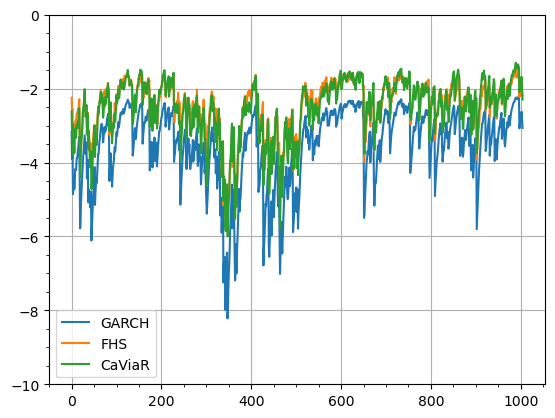

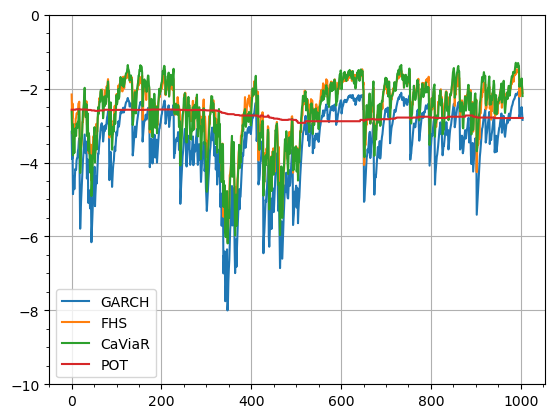

In [ ]:
# This is for the static approach.
plt.plot(oos_VaR_GARCH["AAPL"][-test_window:].reset_index(drop=True), label="GARCH")
plt.plot(oos_FHS["AAPL"][-test_window:].reset_index(drop=True), label="FHS")
plt.plot(oos_filtered_CaViaR["AAPL"][-test_window:].reset_index(drop=True), label="CaViaR")
plt.ylim(-10, 0)
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

# Plot the time series. This is for the dynamic approach.
plt.plot(GARCH_VaR["AAPL"], label="GARCH")
plt.plot(FHS_VaR["AAPL"], label="FHS")
plt.plot(CaViaR_VaR["AAPL"], label="CaViaR")
plt.plot(POT_VaR["AAPL"], label="POT")
plt.ylim(-10, 0)
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

In [ ]:
# Save the dataframes of each VaR approach. These can be thrown into the Christoffersen test.
violation_GARCH_dyn = check_violations(GARCH_VaR, returns[-test_window:], pd.DataFrame())
violation_FHS_dyn = check_violations(FHS_VaR, returns[-test_window:], pd.DataFrame())
violation_CaViaR_dyn = check_violations(CaViaR_VaR, returns[-test_window:], pd.DataFrame())
violation_POT_dyn = check_violations(POT_VaR, returns[-test_window:], pd.DataFrame())
# violation_CoVaR_dyn = check_violations(CoVaR_VaR, returns[-test_window:], pd.DataFrame())

In [ ]:
# For dynamic GARCH.
print("\n\nFor dynamic GARCH:")
run_christoffersen(violation_GARCH_dyn, quantile)

# For dynamic FHS.
print("\n\nFor dynamic FHS:")
run_christoffersen(violation_FHS_dyn, quantile)

# For dynamic CaViaR.
print("\n\nFor dynamic CaViaR:")
run_christoffersen(violation_CaViaR_dyn, quantile)

# For dynamic POT.
print("\n\nFor dynamic POT:")
run_christoffersen(violation_POT_dyn, quantile)

# # For dynamic CoVaR.
# print("\n\nFor dynamic CoVaR:")
# run_christoffersen(violation_CoVaR_dyn, quantile)



For dynamic GARCH:
& \textbf{AAPL} & \textbf{0.000} & 0.343 & \textbf{0.000} & 0.420\\
& \textbf{AMZN} & \textbf{0.000} & 0.392 & \textbf{0.000} & 0.380\\
& \textbf{AVGO} & \textbf{0.000} & 0.472 & \textbf{0.000} & 0.320\\
& \textbf{JPM} & \textbf{0.000} & 0.258 & \textbf{0.000} & 0.500\\
& \textbf{META} & \textbf{0.000} & 0.702 & \textbf{0.001} & 0.520\\
& \textbf{MSFT} & \textbf{0.002} & 0.174 & \textbf{0.003} & 0.600\\
& \textbf{NVDA} & \textbf{0.000} & 0.590 & \textbf{0.000} & 0.240\\
& \textbf{TSLA} & \textbf{0.000} & 0.444 & \textbf{0.000} & 0.340\\
& \textbf{V} & \textbf{0.000} & 0.205 & \textbf{0.001} & 0.560\\


For dynamic FHS:
& \textbf{AAPL} & 0.914 & 0.853 & 0.977 & 1.020\\
& \textbf{AMZN} & 0.132 & 0.687 & 0.296 & 1.220\\
& \textbf{AVGO} & 0.592 & 0.201 & 0.382 & 1.080\\
& \textbf{JPM} & 0.338 & 0.888 & 0.626 & 1.140\\
& \textbf{META} & 0.801 & 0.642 & 0.870 & 1.040\\
& \textbf{MSFT} & 0.132 & \textbf{0.006} & \textbf{0.007} & 1.220\\
& \textbf{NVDA} & 0.132 & 0.687 & 0

## Black Litterman

In [ ]:
"""
black_litterman
Takes in the data and all vectors/matrices that are relevant for the computation of the Black-Litterman model. 
These are P (selection matrix), Q (guess or expert opinion), Sigma (variance of returns), Omega (variance of 
the guess) and tau (certainty guess). Then the function calculates the Black-Litterman transformed data and
returns that.
"""

# Function to calculate the Bayesian Black-Litterman transformed data.
def black_litterman(data, P, Q, Sigma, Omega, tau):
    first_term = np.linalg.inv(tau * Sigma) + P.T @ np.linalg.inv(Omega) @ P
    second_term = np.linalg.inv(tau * Sigma) @ data + P.T @ np.linalg.inv(Omega) @ Q
    data_BL = np.linalg.inv(first_term) @ second_term

    return data_BL

In [ ]:
"""
scalar_black_litterman
Takes in the data and all scalar forms of the values that are relevant for the computation of the Black-Litterman 
model. These are Q (guess or expert opinion), Sigma (variance of returns), Omega (variance of the guess) and tau 
(certainty guess). Then the function calculates the Black-Litterman transformed data and returns that. Only works
when all values are scalars, for matrices use black_litterman instead!
"""

# Function to calculate the Bayesian Black-Litterman transformed data, but accepts only scalar.
def scalar_black_litterman(data, Q, Sigma, Omega, tau):
    first_term = 1 / (tau * Sigma) + 1 / Omega
    second_term = data / (tau * Sigma) + Q / Omega
    data_BL = second_term / first_term

    return data_BL

In [ ]:
"""
weight_function
Takes in the data and a weight type, uses that to compute a weighted sum of the data. This can then be used in
the Black-Litterman model. Supported weight types are "equal" (average), "1/x" and "exp". The last two can be
used to obtain non-linear weighted average. Then it returns this value.
"""

# Function to compute the weights and return the weighted data.
def weight_function(data, weight_type="equal"):

    # Define the length of the dataset.
    T = len(data)

    # In case of equal weights (mean).
    if weight_type == "equal":
        norm_weights = np.ones(T)/T
    
    # In case of 1/x weights, it must be normalized to 1.
    elif weight_type == "1/x":
        weights = np.array([1/(index+1) for index in range(T)])
        norm_weights = weights / sum(weights)
    
    # In case of exp weights, it must be normalized to 1.
    elif weight_type == "exp":
        weights = np.array([np.exp(-index) for index in range(T)])
        norm_weights = weights / sum(weights)
    
    # Return the weighted data.
    return np.array(np.sum(data.mul(norm_weights, axis='index')))

### Single Approach

In [ ]:
"""
BL_VaR_single
Takes in a form of filtered VaR, the size of the window, a list of guesses (expert opinions) and the weight type.
Then for each stock if computes the Black-Litterman altered values of the VaR and saves the altered VaRs into a 
new dataframe. It also saves the averages from the weighting function, and returns the average and the altered
VaR estimates.
"""

# Function to obtain the univariate Black-Litterman VaR/returns based on given inputs.
def BL_VaR_single(input_data, window_size, Q_list, weight_type="equal"):

    # Define length and initialize arrays.
    T = len(input_data)
    sample_means = np.zeros(T-window_size)
    sample_BL = np.zeros(T-window_size)

    # Generate the dataframes and set the date column.
    stocks = [col for col in input_data.columns if col not in ["date"]]
    average_df = pd.DataFrame(0, index=range(T-window_size), columns=["date"] + stocks)
    BL_df = pd.DataFrame(0, index=range(T-window_size), columns=["date"] + stocks)
    average_df["date"] = returns["date"].iloc[-T+window_size:].reset_index(drop=True)
    BL_df["date"] = returns["date"].iloc[-T+window_size:].reset_index(drop=True)

    # Loop through all the stocks.
    for stock_index, stock in enumerate(stocks):

        # Define the variables to call the BL model.
        Sigma = np.var(input_data[stock])       # Variance-covariance matrix returns
        Q = Q_list[stock_index]                 # Goal
        Omega = 1                               # Variance in guess
        tau = 0.075                             # Certainty guess

        # Loop through all the window opportunities in the given data.
        # The +1 in sample_data ensures alignment!
        for index in range(T - window_size):
            end_index = index + window_size
            sample_data = input_data[stock][index+1:end_index+1]

            # Call the weighting function to obtain the correct values (when window_size > 1).
            mu = np.array([weight_function(sample_data, weight_type)])

            # Call the black_litterman function to obtain the posterior and save them.
            BL_value = scalar_black_litterman(mu, Q, Sigma, Omega, tau)
            sample_means[index] = mu
            sample_BL[index] = BL_value

        # Save the arrays into the dataframe.
        average_df[stock] = sample_means
        BL_df[stock] = sample_BL

    return average_df, BL_df

In [ ]:
# Define the values of tau and Omega for CaViaR.
T = len(CaViaR_VaR)
window_size = 1
Q_list = [-5, -6, -6, -4, -5, -6, -5, -9, -6]

# Run the function to obtain the posterior Black-Litterman VaR and apply backtesting.
print("For the Black-Litterman approach of the CaViaR model:")
BL_CaViaR_uni = BL_VaR_single(oos_filtered_CaViaR[-T:], window_size, Q_list, weight_type="equal")[1]
run_christoffersen(check_violations(BL_CaViaR_uni[stocks], returns[-(T-window_size):].reset_index(), pd.DataFrame()), quantile)

print("\nFor the regular approach of the CaViaR model:")
run_christoffersen(check_violations(oos_filtered_CaViaR[-T:], returns[-T:].reset_index(), pd.DataFrame()), quantile)


# Define the values of Q for FHS.
Q_list = [-8, -7, -7, -6, -3, -10, -9, -9, -3]

# Run the function to obtain the posterior Black-Litterman VaR and apply backtesting.
print("\n\nFor the Black-Litterman approach of the FHS model:")
BL_FHS_uni = BL_VaR_single(oos_FHS[-T:], window_size, Q_list, weight_type="equal")[1]
run_christoffersen(check_violations(BL_FHS_uni[stocks], returns[-(T-window_size):].reset_index(), pd.DataFrame()), quantile)

print("\nFor the regular approach of the FHS model:")
run_christoffersen(check_violations(oos_FHS[-T:], returns[-T:].reset_index(), pd.DataFrame()), quantile)

For the Black-Litterman approach of the CaViaR model:
& \textbf{AAPL} & 0.795 & 0.641 & 0.867 & 1.040\\
& \textbf{AMZN} & 0.977 & 0.263 & 0.534 & 1.000\\
& \textbf{AVGO} & 0.862 & 0.289 & 0.561 & 0.980\\
& \textbf{JPM} & 0.977 & 0.263 & 0.534 & 1.000\\
& \textbf{META} & 0.977 & 0.263 & 0.534 & 1.000\\
& \textbf{MSFT} & 0.908 & \textbf{0.019} & 0.065 & 1.020\\
& \textbf{NVDA} & 0.977 & 0.263 & 0.534 & 1.000\\
& \textbf{TSLA} & 0.977 & 0.735 & 0.944 & 1.000\\
& \textbf{V} & 0.444 & 0.988 & 0.746 & 0.900\\

For the regular approach of the CaViaR model:
& \textbf{AAPL} & 0.217 & 0.367 & 0.311 & 1.180\\
& \textbf{AMZN} & \textbf{0.021} & \textbf{0.037} & \textbf{0.008} & 1.340\\
& \textbf{AVGO} & 0.170 & 0.104 & 0.104 & 1.200\\
& \textbf{JPM} & 0.413 & 0.940 & 0.714 & 1.120\\
& \textbf{META} & 0.413 & 0.143 & 0.245 & 1.120\\
& \textbf{MSFT} & \textbf{0.041} & 0.056 & \textbf{0.020} & 1.300\\
& \textbf{NVDA} & 0.273 & 0.115 & 0.158 & 1.160\\
& \textbf{TSLA} & 0.132 & 0.306 & 0.190 & 1.220\\


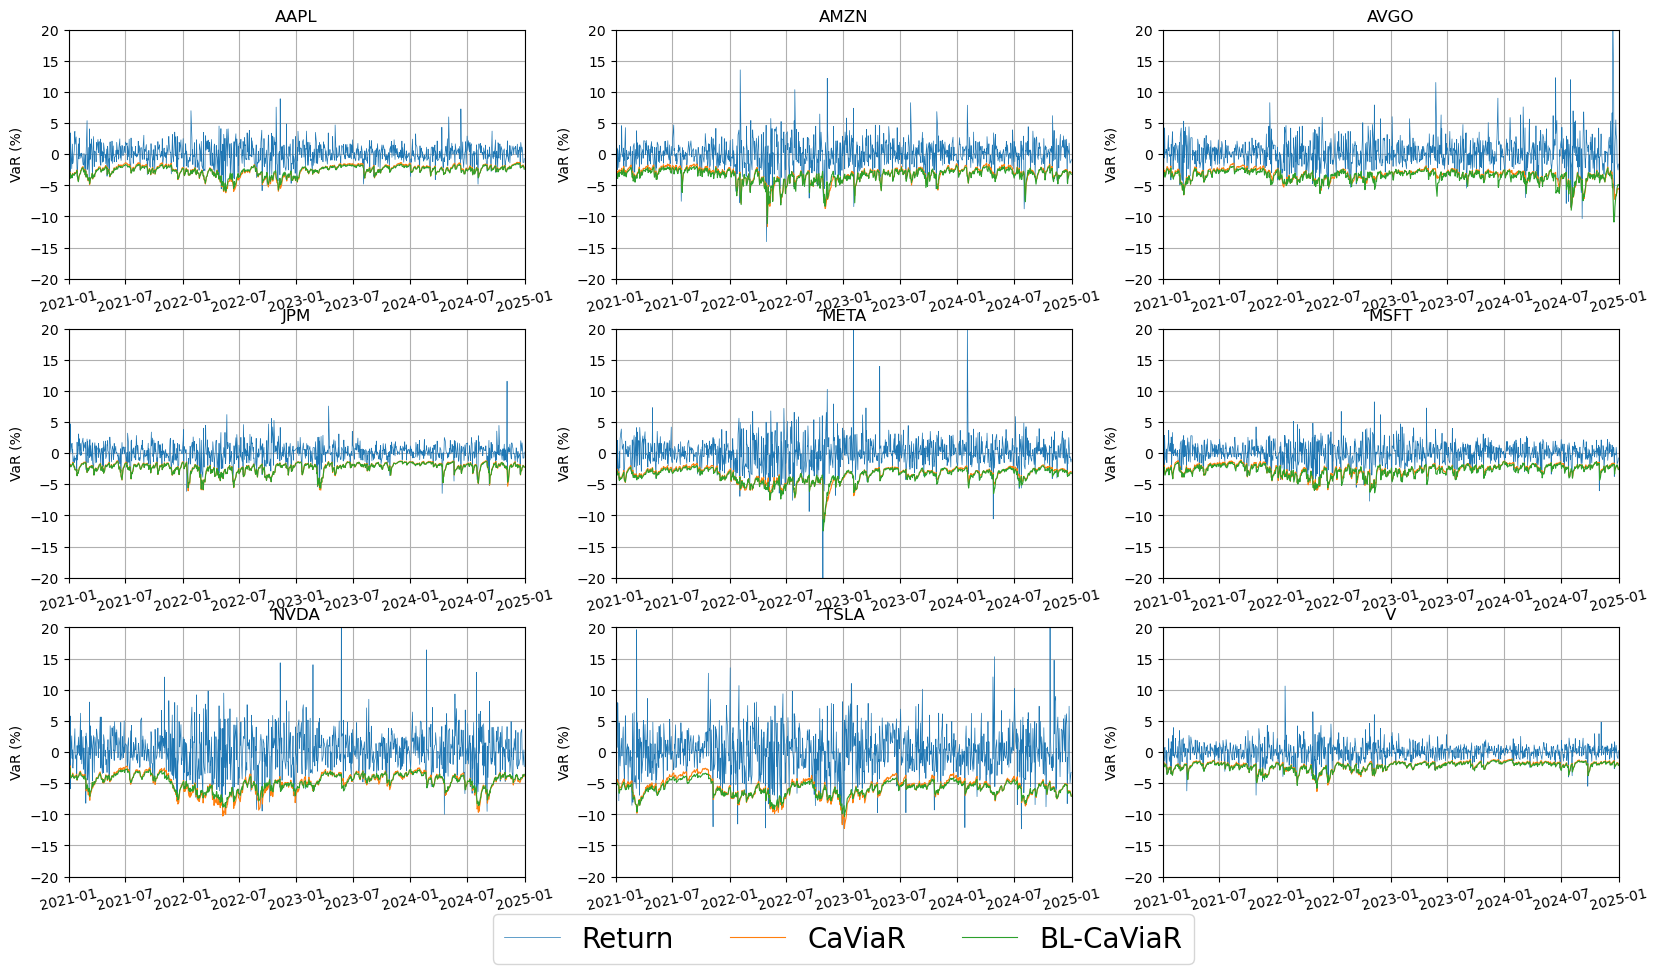

In [ ]:
# Set figure size.
plt.figure(figsize=(20, 11))

# Make a plot of all time series.
for index, stock in enumerate(stocks):
    plt.subplot(3, 3, index + 1)
    plt.plot(returns["date"], returns[stock], linewidth=0.5, label="Return")
    plt.plot(returns["date"][-T:], CaViaR_VaR[stock], linewidth=0.8, label="CaViaR")
    plt.plot(returns["date"][-(T-1):], BL_CaViaR_uni[stock], linewidth=0.8, label="BL-CaViaR")
    plt.xlim(pd.to_datetime("2021-01-01"), end_date)
    plt.xticks(rotation=12.5)
    plt.ylim(-20, 20)
    # plt.xlabel("Date")
    plt.ylabel("VaR (%)")
    plt.title(stock)
    plt.grid()

plt.legend(fontsize=20, loc='center left', bbox_to_anchor=(-1.5, -0.25), ncol=3)
plt.savefig("Figures/BL_single_VaR.png", bbox_inches='tight', facecolor='w', dpi = 300)

### Multiple Approach

In [ ]:
"""
BL_VaR_multiple
Takes in a form of filtered VaR, the size of the window, the value for tau, the matrix of Omega, the selection matrix P, 
a list of guesses (expert opinions) and the weight type. Then for each stock if computes the Black-Litterman altered 
values of the VaR and saves the altered VaRs into a new dataframe. This approach works for multiple stocks at once, so
you can for example say that the VaR of AAPL will be 2% lower than MSFT. It also saves the averages from the weighting 
function, and returns the average and the altered VaR estimates.
"""

# Function to obtain the multivariate Black-Litterman VaR/returns based on given inputs.
def BL_VaR_multiple(input_data, window_size, tau, Omega, P, Q, weight_type="equal"):

    # Define length and initialize arrays.
    T = len(input_data)

    # Generate the dataframes and set the date column.
    stocks = [col for col in input_data.columns if col not in ["date"]]
    BL_df = pd.DataFrame(0, index=range(T-window_size), columns=["date"] + stocks)
    BL_df["date"] = returns["date"].iloc[-T+window_size:].reset_index(drop=True)

    # Define the variance-covariance matrix to call the BL model.
    Sigma = np.cov(input_data.T)

    # Loop through all the window opportunities in the given data.
    # The +1 in sample_data ensures alignment!
    for index in range(T - window_size):
        end_index = index + window_size
        sample_data = input_data[index+1:end_index+1]

        # Call the weight averaging function to obtain the correct weights (when window_size > 1).
        mu = weight_function(sample_data, weight_type)

        # Call the black_litterman function to obtain the posterior and save them.
        BL_value = black_litterman(mu, P, Q, Sigma, Omega, tau)

        # Save the arrays into the dataframe.
        BL_df.iloc[index, 1:] = BL_value

    return BL_df

In [ ]:
# Define the parameters required for the BL approach.
original_VaR = oos_filtered_CaViaR[-T:]
window_size = 1
P = np.array([[1, 0, 0, 0, -1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, -1, 0, 0]])
Q = np.array([5, 4])
Omega = np.diag([2, 3])
tau = 0.25

# Call the BL function to obtain new estimates of VaR.
BL_CaViaR_multi = BL_VaR_multiple(original_VaR, window_size, tau, Omega, P, Q, weight_type="equal")

In [ ]:
# Run the function to obtain the posterior Black-Litterman VaR and apply backtesting.
print("For the Multivariate Black-Litterman approach of the CaViaR model:")
BL_CaViaR_multi = BL_VaR_multiple(original_VaR, window_size, tau, Omega, P, Q, weight_type="equal")
run_christoffersen(check_violations(BL_CaViaR_multi[stocks], returns[-(T-window_size):].reset_index(drop=True), pd.DataFrame()), quantile)

print("\nFor the regular approach of the CaViaR model:")
run_christoffersen(check_violations(original_VaR[stocks], returns[-T:].reset_index(drop=True), pd.DataFrame()), quantile)

For the Multivariate Black-Litterman approach of the CaViaR model:
& \textbf{AAPL} & 0.688 & 0.196 & 0.400 & 1.060\\
& \textbf{AMZN} & 0.748 & 0.316 & 0.574 & 0.960\\
& \textbf{AVGO} & 0.130 & 0.080 & 0.069 & 1.220\\
& \textbf{JPM} & 0.908 & 0.239 & 0.496 & 1.020\\
& \textbf{META} & 0.126 & 0.600 & 0.271 & 0.800\\
& \textbf{MSFT} & 0.360 & \textbf{0.044} & 0.087 & 0.880\\
& \textbf{NVDA} & 0.126 & 0.068 & 0.059 & 0.800\\
& \textbf{TSLA} & 0.409 & 0.473 & 0.550 & 1.120\\
& \textbf{V} & 0.444 & 0.988 & 0.746 & 0.900\\

For the regular approach of the CaViaR model:
& \textbf{AAPL} & 0.217 & 0.367 & 0.311 & 1.180\\
& \textbf{AMZN} & \textbf{0.021} & \textbf{0.037} & \textbf{0.008} & 1.340\\
& \textbf{AVGO} & 0.170 & 0.104 & 0.104 & 1.200\\
& \textbf{JPM} & 0.413 & 0.940 & 0.714 & 1.120\\
& \textbf{META} & 0.413 & 0.143 & 0.245 & 1.120\\
& \textbf{MSFT} & \textbf{0.041} & 0.056 & \textbf{0.020} & 1.300\\
& \textbf{NVDA} & 0.273 & 0.115 & 0.158 & 1.160\\
& \textbf{TSLA} & 0.132 & 0.306 & 0.1

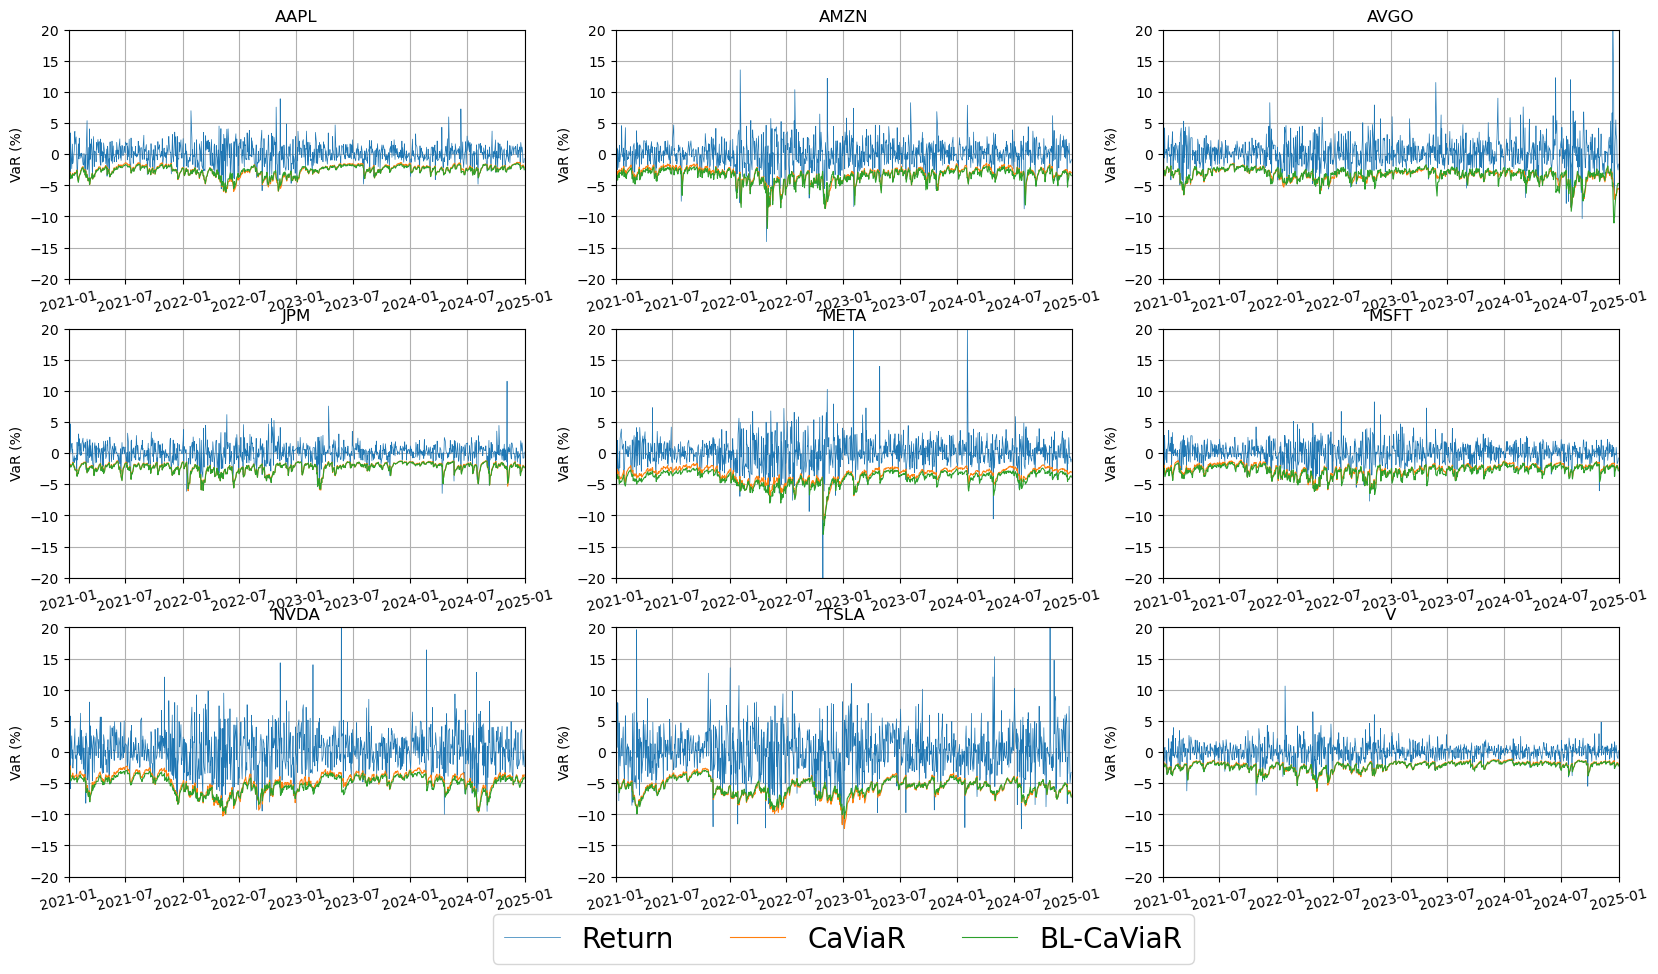

In [ ]:
# Set figure size.
plt.figure(figsize=(20, 11))

# Make a plot of all time series.
for index, stock in enumerate(stocks):
    plt.subplot(3, 3, index + 1)
    plt.plot(returns["date"], returns[stock], linewidth=0.5, label="Return")
    plt.plot(returns["date"][-T:], CaViaR_VaR[stock], linewidth=0.8, label="CaViaR")
    plt.plot(returns["date"][-(T-1):], BL_CaViaR_multi[stock], linewidth=0.8, label="BL-CaViaR")
    plt.xlim(pd.to_datetime("2021-01-01"), end_date)
    plt.xticks(rotation=12.5)
    plt.ylim(-20, 20)
    # plt.xlabel("Date")
    plt.ylabel("VaR (%)")
    plt.title(stock)
    plt.grid()

plt.legend(fontsize=20, loc='center left', bbox_to_anchor=(-1.5, -0.25), ncol=3)
plt.savefig("Figures/BL_multiple_VaR.png", bbox_inches='tight', facecolor='w', dpi = 300)

### Implied VaR

In [ ]:
# Read the raw returns, downloaded from WRDS and set formats.
raw_SP100 = pd.read_csv("Data/SP100_returns.csv")
raw_SP100["RET"] = (pd.to_numeric(raw_SP100["RET"], errors="coerce") * 100)
raw_SP100["date"] = pd.to_datetime(raw_SP100["date"], format="%d/%m/%Y")

# Put every stock in its own column.
raw_SP100 = raw_SP100.dropna()
SP100_full_returns = raw_SP100.pivot(index="date", columns="TICKER", values="RET").reset_index()
SP100_full_returns = SP100_full_returns.dropna(axis=1)
stocks = [col for col in SP100_full_returns.columns if col not in ["date"]]

# Control if we want to grid search the CaViaR, not needed when csv's are already supplied.
grid_search_CaViaR = False
threshold_Q = 30

In [ ]:
"""
BL_VaR_optimize
Takes in the filtered variance, the full returns, the window size, the end year of the testing window and the relevant
stocks. Then it runs through each stock, checks which value of Q in the Black-Litterman model results in a VR between 
0.95 and 1.05. Once it finds it, it is saved as "implied_Q". Since sometimes it is stuck jumping between <0.95 and >1.05, 
it drops once 200 iterations are done. Every entry of implied_Q below -30 or above 30 are removed, since they influence 
the OLS estimate to much. The list of implied_Q is then returned from the function.
"""

# Function to calculate the optimal value of Q for the BL model.
def BL_VaR_optimize(input_data, returns, window_size, year, stocks, tau, Omega):

    # Define length and initialize arrays.
    T = len(input_data)

    # Generate the dataframes/arrays and set the date column.
    BL_df = pd.DataFrame(0, index=range(T-window_size), columns=["date"])
    BL_df["date"] = returns["date"].iloc[-T+window_size:].reset_index(drop=True)
    implied_Q = np.zeros(len(stocks))
    limit_exceeded = []

    # Loop through all the stocks.
    for stock_index, stock in enumerate(stocks):

        # Print the progress.
        print(f"Running Black-Litterman approach for stock {stock_index+1}/{len(stocks)} for {year}", end="\r")

        # Define the variables to call the BL model.
        Sigma = np.var(input_data[stock])  # Variance returns
        Q = -4                             # Starting value of the goal.
        # Omega = 1                          # Variance in guess
        # tau = 0.075                        # Certainty guess

        # Initialize an array for BL estimates of VaR.
        sample_BL = np.zeros(T-window_size)

        # Calculate the current VR, so we know what direction the goal should be towards.
        current_VR = np.sum((returns[stock][-T:].values < input_data[stock].values).astype(int)) / (quantile * T)
        optimized = False
        counter = 0
        Q_step = 0.5
        
        # If the VR is already between 0.95 and 1.05, consider the VR to be sufficient already.
        if 0.95 < current_VR < 1.05:
            optimized = True

        # As long as we are not in that region, check new "implied" VaR.
        while not optimized:

            # Keep a counter and make the steps smaller when convergence doesn't occur yet.
            counter += 1
            if counter % 50 == 0:
                Q_step = Q_step / 2

            # Loop through all the window opportunities in the given data.
            # The +1 in sample_data ensures alignment!
            for index in range(T - window_size):
                end_index = index + window_size
                mu = input_data[stock][index+1:end_index+1]

                # Call the black_litterman function to obtain the posterior and save it.
                BL_value = scalar_black_litterman(mu, Q, Sigma, Omega, tau)
                sample_BL[index] = BL_value

            # Check the violations.
            VR = np.sum((returns[stock][-(T-1):].values < sample_BL).astype(int)) / (quantile * T)

            # Check optimization status and give direction for next guess of Q.
            if 0.95 < VR < 1.05 or abs(Q) > threshold_Q or counter >= 200:
                optimized = True

            # If VR is too low, -VaR estimate should go up to compensate.
            elif VR < 1:
                Q += Q_step

            # If VR is too high, -VaR estimate should go down to compensate.
            elif VR >= 1:
                Q -= Q_step

        # Save the arrays.
        BL_df[stock] = sample_BL
        implied_Q[stock_index] = Q

        # Save the stocks that exceed a limit of abs(Q)>threshold, so we can remove these from regression later.
        if abs(Q) > threshold_Q:
            limit_exceeded.append(stock)

    return BL_df, implied_Q, limit_exceeded

In [ ]:
"""
Takes in the filtered VaR, the full set of return data, the OLS estimates a and b, the value of the excess MAR (or volatility 
in case of STD/GARCH), the included stocks, the current list of VRs from the Black-Litterman approach and the regular approach, 
the type of VaR (CaViaR or FHS) and the type of Q (MAR, STD or GARCH), the method (either dynamic or static), and finally if it 
should plot or not. It then calculates based on the estimated parameters in the function "generate_static_Q_plot" later on what 
a good value of Q should be and uses that to compute the Black-Litterman altered VaR. After that, it computes the VR and makes 
a histogram of this for both the original approach and the Black-Litterman approach. These can then be compared to check performance.
""" 

# Function to plot a histogram of the VR, before and after the Black-Litterman model.
def make_histogram(filtered_VaR, full_data, a, b, excess, stocks, BL_list, ORIG_list, VaR_type, Q_type, method, plotting):
    
    # Define variables.
    window_size = 1
    T = len(filtered_VaR)

    # Define the variables based on OLS of that year to test the theory.
    Q_predicted = a*excess + b

    # Calculate the VaR using BL approach and obtain the VR.
    BL_CaViaR_uni = BL_VaR_single(filtered_VaR[stocks], window_size, Q_predicted, weight_type="equal")[1]
    violation_df = check_violations(BL_CaViaR_uni[stocks], full_data[stocks][-(T-window_size):].reset_index(drop=True), pd.DataFrame())
    VR_BL = list(violation_df.sum() / (quantile*T))
    BL_list.extend(VR_BL)

    # Also compute VR for the original approach to compare to.
    VR_ORIG = list(check_violations(filtered_VaR[stocks], full_data[-T:].reset_index(), pd.DataFrame()).sum() / (quantile*T))
    ORIG_list.extend(VR_ORIG)

    # Only plot the last iteration, since we are only interested in the resulting figure.
    if plotting:

        # Run a Jarque-Bera test. No real reason to do so, just curious.
        JB_stat_ORIG, JB_p_ORIG = jarque_bera(ORIG_list)
        JB_stat_BL, JB_p_BL = jarque_bera(BL_list)
        print(f"The Jarque-Bera test on the original VaR gives a t-statistic of {JB_stat_ORIG}, corresponding to a p-value of {JB_p_ORIG}")
        print(f"The Jarque-Bera test on the Black-Litterman VaR gives a t-statistic of {JB_stat_BL}, corresponding to a p-value of {JB_p_BL}")

        # Set figure size
        plt.figure(figsize=(6, 5))
        plt.hist(ORIG_list, bins=20)
        plt.title(f"VR Original | {VaR_type} | {method}", fontsize=15)
        plt.xlabel("Violation Ratio (VR)")
        plt.ylabel("Frequency")
        plt.grid()
        plt.savefig("Figures/"+method[0]+"H_"+VaR_type+".png", bbox_inches='tight', facecolor='w', dpi = 300)
        plt.show()

        plt.figure(figsize=(6, 5))
        plt.hist(BL_list, bins=20)
        plt.title(f"VR Black-Litterman | {VaR_type} | {Q_type} | {method}", fontsize=15)
        plt.xlabel("Violation Ratio (VR)")
        plt.ylabel("Frequency")
        plt.grid()
        plt.savefig("Figures/"+method[0]+"H_"+VaR_type+"_"+Q_type+".png", bbox_inches='tight', facecolor='w', dpi = 300)
        plt.show()
        
    return BL_list, ORIG_list

In [ ]:
"""
run_OLS
takes in the excess MAR (or volatility in case of STD/GARCH) and the corresponding values of the implied Q. These are then
used to perform OLS and obtain a relation between the dependent and independent variable. These lines are then drawn and
saved for later to plot.
"""

# Function to run the OLS between excess and kept_Q.
def run_OLS(excess, kept_Q):

    # Run the OLS regression, print summary and save the r^2.
    X = sm.add_constant(excess)
    model = sm.OLS(kept_Q, X, missing = 'drop')
    results = model.fit(cov_type='HC0')
    r2 = format(results.rsquared, ".3f")
    print(results.summary())

    # Generate the line obtained from the OLS to plot.
    x = np.linspace(-10, 10)
    b, a = results.params
    y = a*x+b
    print("OLS parameters are:", a, b)
    
    return a, b, x, y, r2

In [ ]:
"""
plot_Qplot
Takes in the plotting dictionary consisting of the lines drawn in run_OLS, the full list of datapoints for the x-axis,
the full list of datapoints for the y-axis, the type of VaR used (CaViaR or FHS), the type of Q used (MAR, STD or GARCH),
and finally the method (either dynamic or static). It also plots the corresponding values of MAR/STD/GARCH on the x-axis 
and the implied_Q on the y-axis. Based on the type of figure it needs to create, it ends up at different if-statements. 
In the end it shows the different lines and datapoints in a single figure.
"""

# Function to make the Q-plot.
def plot_Qplot(plot_dict, full_excess, full_Q, VaR_type, Q_type, method):
    
    # Define the number of lines T and show the final one as the combined.
    T = len(plot_dict["label"]) - 1
    for index in range(T):
        plt.plot(plot_dict["x_data"][index], plot_dict["y_data"][index], label=plot_dict["label"][index])

    plt.plot(plot_dict["x_data"][T], plot_dict["y_data"][T], label=plot_dict["label"][T], color="black")
    plt.plot(full_excess, full_Q, "kx", color="black", markersize=1)
    plt.ylabel("Implied VaR (Q)")
    plt.ylim(-30, 30)
    plt.grid()
    plt.legend(fontsize="x-small", loc="upper right")
    
    # Add additional things in case of MAR.
    if Q_type == "MAR":
        plt.title("Relation Q and MAR | " + VaR_type + " | " + method, fontsize=15)
        plt.xlabel("Excess mean absolute return (OOS-IN)")
        plt.xlim(-1, 1.5)
        plt.savefig("Figures/"+method[0]+"Q_plot_"+VaR_type+"_MAR.png", bbox_inches='tight', facecolor='w', dpi = 300)

    # Add additional things in case of STD.
    elif Q_type == "STD":
        plt.title("Relation Q and volatility | " + VaR_type + " | " + method, fontsize=15)
        plt.xlabel("Volatility (Sample standard deviation)")
        plt.xlim(0, 6)
        plt.savefig("Figures/"+method[0]+"Q_plot_"+VaR_type+"_STD.png", bbox_inches='tight', facecolor='w', dpi = 300)

    # Add additional things in case of GARCH.
    elif Q_type == "GARCH": 
        plt.title("Relation Q and volatility | " + VaR_type + " | " + method, fontsize=15)
        plt.xlabel("Volatility (GJR-GARCH(1,1) st.t.)")
        plt.xlim(0, 7)
        plt.savefig("Figures/"+method[0]+"Q_plot_"+VaR_type+"_GAR.png", bbox_inches='tight', facecolor='w', dpi = 300)

    # Show the figure.
    plt.show()


For CaViaR in 2019:
Convergence: True - AAPL
Convergence: True - ABT
Convergence: True - ACN
Convergence: True - ADBE
Convergence: True - ADI
Convergence: True - ADP
Convergence: True - AMAT
Convergence: True - AMD
Convergence: True - AMGN
Convergence: True - AMT
Convergence: True - AMZN
Convergence: True - APH
Convergence: True - AVGO
Convergence: True - AXP
Convergence: True - BA
Convergence: True - BAC
Convergence: True - BH
Convergence: True - BLK
Convergence: True - BSX
Convergence: True - BX
Convergence: True - C
Convergence: True - CAT
Convergence: True - CB
Convergence: True - CME
Convergence: True - CMT
Convergence: True - COP
Convergence: True - COST
Convergence: True - CRM
Convergence: True - CSCO
Convergence: True - CVX
Convergence: True - DE
Convergence: True - DHR
Convergence: True - DIS
Convergence: True - ETN
Convergence: True - GE
Convergence: True - GILD
Convergence: True - GS
Convergence: True - HD
Convergence: True - HON
Convergence: True - IBM
Convergence: True - 

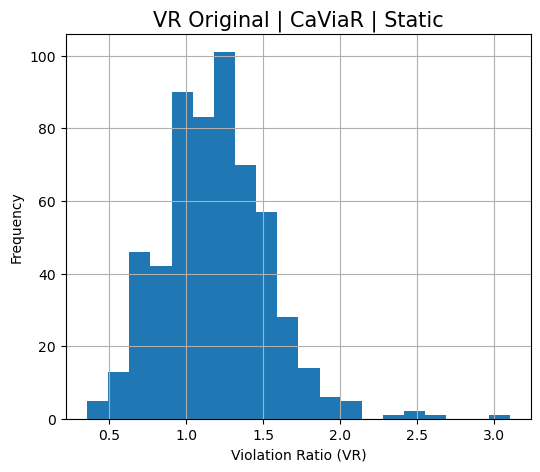

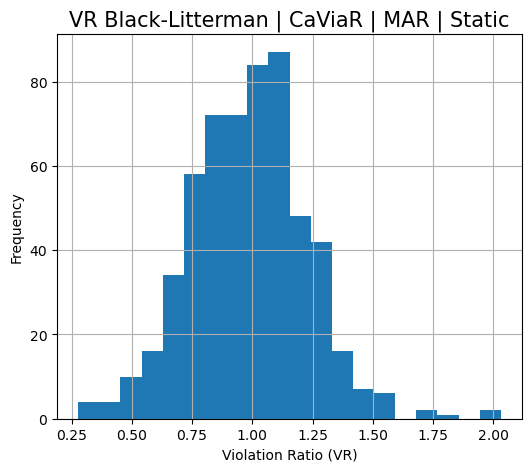

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     117.7
Date:                 wo, 25 jun 2025   Prob (F-statistic):           5.02e-25
Time:                        13:25:45   Log-Likelihood:                -1918.3
No. Observations:                 565   AIC:                             3841.
Df Residuals:                     563   BIC:                             3849.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2362      0.362     -8.930      0.0

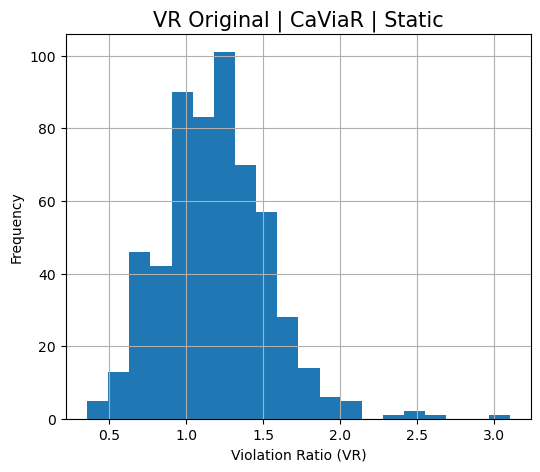

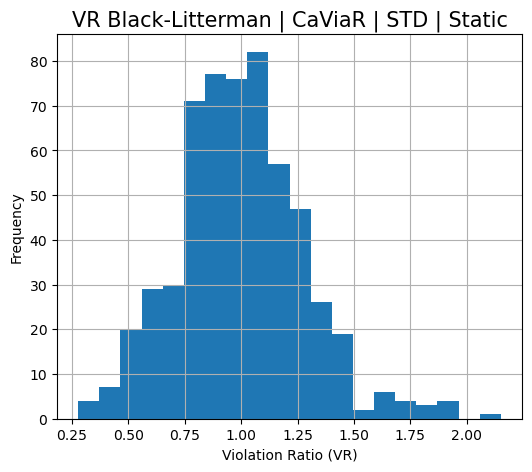

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     29.06
Date:                 wo, 25 jun 2025   Prob (F-statistic):           1.03e-07
Time:                        13:42:51   Log-Likelihood:                -1978.9
No. Observations:                 565   AIC:                             3962.
Df Residuals:                     563   BIC:                             3970.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1669      0.895    -10.239      0.0

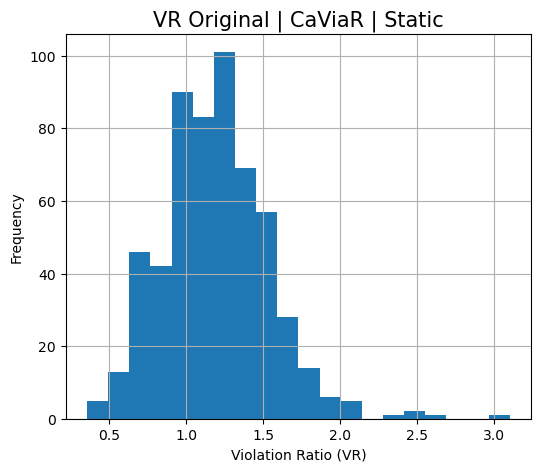

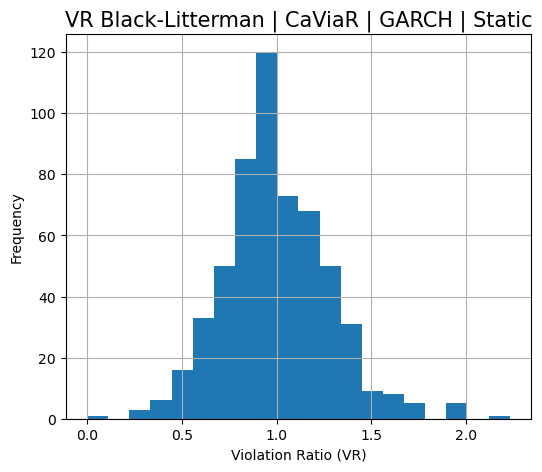

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.800
Date:                 wo, 25 jun 2025   Prob (F-statistic):             0.0948
Time:                        13:58:56   Log-Likelihood:                -1982.7
No. Observations:                 563   AIC:                             3969.
Df Residuals:                     561   BIC:                             3978.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7545      0.740     -7.779      0.0

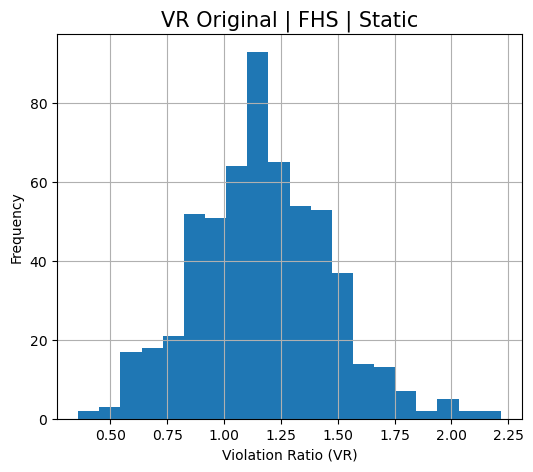

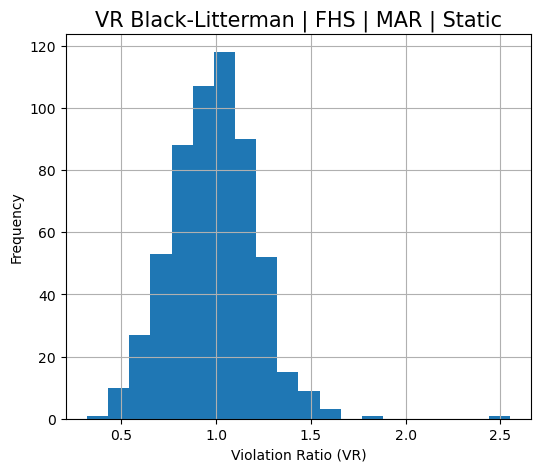

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     72.20
Date:                 wo, 25 jun 2025   Prob (F-statistic):           1.69e-16
Time:                        14:08:23   Log-Likelihood:                -1856.3
No. Observations:                 575   AIC:                             3717.
Df Residuals:                     573   BIC:                             3725.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3265      0.336     -9.902      0.0

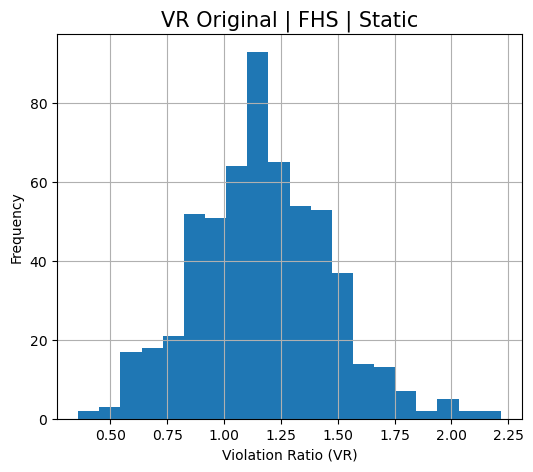

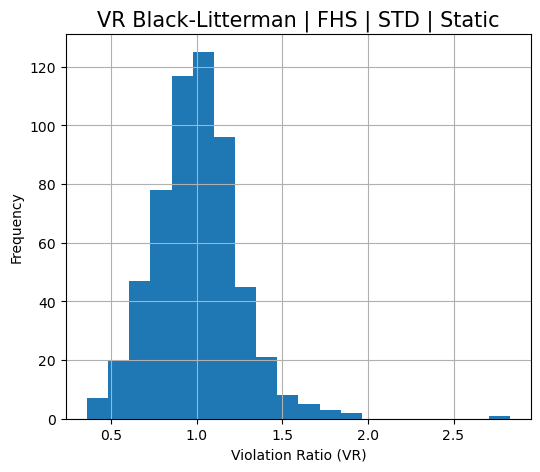

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     13.54
Date:                 wo, 25 jun 2025   Prob (F-statistic):           0.000255
Time:                        14:17:46   Log-Likelihood:                -1900.4
No. Observations:                 575   AIC:                             3805.
Df Residuals:                     573   BIC:                             3814.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.9723      0.710     -9.818      0.0

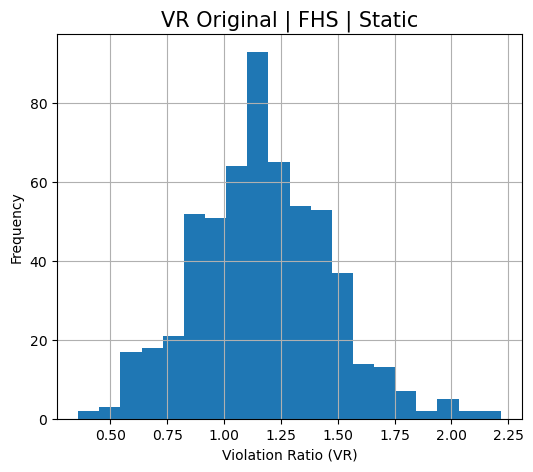

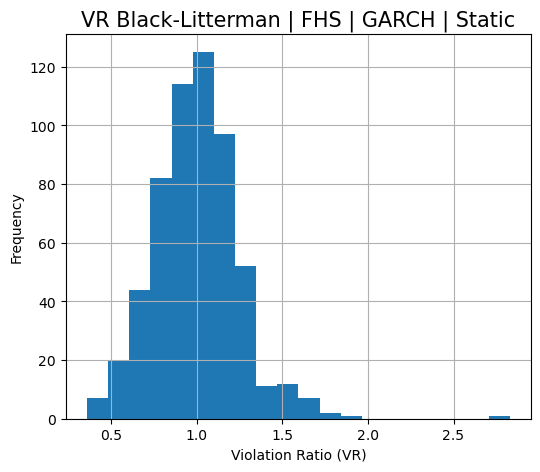

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.238
Date:                 wo, 25 jun 2025   Prob (F-statistic):             0.0225
Time:                        14:29:58   Log-Likelihood:                -1904.3
No. Observations:                 575   AIC:                             3813.
Df Residuals:                     573   BIC:                             3821.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6146      0.610     -9.204      0.0

In [ ]:
"""
generate_static_Q_plot
Takes in the type of VaR that is to be considered, the type of Q we want to estimate, the method (always static), 
and the values for tau and Omega. Then it runs through all possible combinations of a 4-year training and 2-year 
testing window, so we have time-varying results and check if the estimates are constant over time. It then 
selects the correct training and testing windows, which are then fed into the correct VaR estimation model (GARCH, 
FHS or CaViaR). It then calls the BL_VaR_optimize function to obtain the best guesses (implied Q) for Q that give 
a VR of around 1. After that, it calculates the correct value for the  x-axis to plot against and run the OLS to 
obtain the parameters. These are then fed into the histogram function as well. Finally, the lines are saved into 
the dictionary to be used in plot_Qplot to make the plots.
"""

# Function to make the plot of the implied VaR vs fraction.
def generate_static_Q_plot(VaR_type="CaViaR", Q_type="MAR", method="Static", tau=0.075, Omega=1):

    # Define storage for the final regression on all datapoints.
    full_Q = []
    full_excess = []
    BL_list = []
    ORIG_list = []
    plot_dict = {"x_data":[], "y_data":[], "label":[]}

    # Read the initial guesses from the csv.
    SP100_guesses_GARCH = pd.read_csv("Data/GARCH_guesses_SP100.csv") 
    SP100_guesses_CaViaR = pd.read_csv("Data/CaViaR_guesses_SP100.csv") 

    # Define the years of our windows of interest and loop through them.
    window_years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]
    for year in window_years:

        # Obtain the correct stocks and initial guesses
        stocks = [col for col in SP100_full_returns.columns if col not in ["date"]]
        GARCH_guesses = SP100_guesses_GARCH[SP100_guesses_GARCH["year"] == year].drop(columns=["year"])
        CaViaR_guesses = SP100_guesses_CaViaR[SP100_guesses_CaViaR["year"] == year].drop(columns=["year"])

        # Define the dates which the returns need to be based on.
        start_date = "01-01-" + str(year - 6)
        training_date = "01-01-" + str(year - 2)
        end_date = "01-01-" + str(year)

        # Define the training dataframe and the full dataframe.
        # Full dataframe also includes data used for backtesting.
        SP100_returns = SP100_full_returns[(SP100_full_returns["date"] < end_date) & 
                                           (SP100_full_returns["date"] > start_date)].reset_index(drop=True)
        SP100_training = SP100_returns[(SP100_returns["date"] < training_date)].reset_index(drop=True)
        T = len(SP100_training)
        window_size = len(SP100_returns) - T

        # When using the GARCH Q_type, we need to have the GARCH converged as well. 
        # For that reason, first compute which stocks of the GARCH converge and then continue.
        if Q_type == "GARCH":
            stocks = full_GARCH(SP100_returns, SP100_training, stocks, GARCH_guesses, printing=False)[2]

        # In case of the CaViaR.
        if VaR_type == "CaViaR":

            # Obtain the filtered VaR from CaViaR function.
            print(f"\nFor CaViaR in {year}:")
            filtered_VaR = full_CaViaR(SP100_returns, SP100_training, stocks, CaViaR_guesses, year)

        # In case of the GARCH.
        elif VaR_type == "GARCH":
            print(f"\nFor GARCH in {year}:")
            _, filtered_VaR, stocks = full_GARCH(SP100_returns, SP100_training, stocks, GARCH_guesses)

        # In case of the FHS.
        elif VaR_type == "FHS":
            print(f"\nFor FHS in {year}:")
            _, OOS_GARCH_VaR, stocks = full_GARCH(SP100_returns, SP100_training, stocks, GARCH_guesses)
            IS_GARCH_VaR = OOS_GARCH_VaR[:T]
            filtered_VaR = full_FHS(SP100_training, stocks, IS_GARCH_VaR, OOS_GARCH_VaR)[1]

        # Run these through the Black-Litterman VaR optimizer to get implied values of Q.
        _, implied_Q, limit_exceeded = BL_VaR_optimize(filtered_VaR[-window_size:].reset_index(drop=True), SP100_returns, 1, year, stocks, tau, Omega)

        # Define the stocks that were below threshold and calculate the difference in absolute returns.
        kept_stocks = [stock for stock in stocks if stock not in limit_exceeded]
        kept_Q = [Q for Q in implied_Q if abs(Q) <= threshold_Q]
        
        # Compute the Mean Absolute Return when "MAR" is selected.
        if Q_type == "MAR":
            MAR_IS = np.array(np.abs(SP100_returns[kept_stocks][:T]).mean())
            MAR_OS = np.array(np.abs(SP100_returns[kept_stocks][(T+1):]).mean())
            excess = MAR_OS - MAR_IS

        # Compute the sample standard deviation when "STD" is selected.
        if Q_type == "STD":
            excess = np.array(np.std(SP100_returns[kept_stocks][:T]))

        # Compute the filtered GARCH estimate when "GARCH" is selected.
        elif Q_type == "GARCH":
            print(f"\nFor GARCH in {year}:")
            filtered_GARCH = full_GARCH(SP100_returns, SP100_training, kept_stocks, GARCH_guesses)[0]
            excess = np.array(filtered_GARCH.iloc[T])

        # Add the elements of this year to total list.
        full_Q.extend(kept_Q)
        full_excess.extend(excess)

        # Define the OLS so we can check the relation between Q and excess.
        a, b, x, y, r2 = run_OLS(excess, kept_Q)

        # Make the histogram using the function.
        plotting = True if year == 2025 else False
        BL_list, ORIG_list = make_histogram(filtered_VaR[-window_size:].reset_index(drop=True), SP100_returns, 
                                            a, b, excess, kept_stocks, BL_list, ORIG_list, VaR_type, Q_type, method, plotting)

        # Save the data to plot in the graph.
        label = str(year-6)+"-"+str(year-1)+" | "+r"$R^2 = $"+r2
        plot_dict["x_data"].append(x)
        plot_dict["y_data"].append(y)
        plot_dict["label"].append(label)

    # Define the OLS so we can check the relation between Q and excess.
    a, b, x, y, r2 = run_OLS(full_excess, full_Q)

    # Save the combined data to save in the graph.
    label = "Combined  | "+r"$R^2 = $"+r2
    plot_dict["x_data"].append(x)
    plot_dict["y_data"].append(y)
    plot_dict["label"].append(label)

    return plot_dict, full_excess, full_Q

# Runtime ~60 minutes with guesses in csv. Be carefull, prints the last OLS output after histogram!
plot_dict_CaViaR_MAR, full_excess_CaViaR_MAR, full_Q_CaViaR_MAR = generate_static_Q_plot(VaR_type="CaViaR", Q_type="MAR")
plot_dict_CaViaR_STD, full_excess_CaViaR_STD, full_Q_CaViaR_STD = generate_static_Q_plot(VaR_type="CaViaR", Q_type="STD")
plot_dict_CaViaR_GAR, full_excess_CaViaR_GAR, full_Q_CaViaR_GAR = generate_static_Q_plot(VaR_type="CaViaR", Q_type="GARCH")

plot_dict_FHS_MAR, full_excess_FHS_MAR, full_Q_FHS_MAR = generate_static_Q_plot(VaR_type="FHS", Q_type="MAR")
plot_dict_FHS_STD, full_excess_FHS_STD, full_Q_FHS_STD = generate_static_Q_plot(VaR_type="FHS", Q_type="STD")
plot_dict_FHS_GAR, full_excess_FHS_GAR, full_Q_FHS_GAR = generate_static_Q_plot(VaR_type="FHS", Q_type="GARCH")

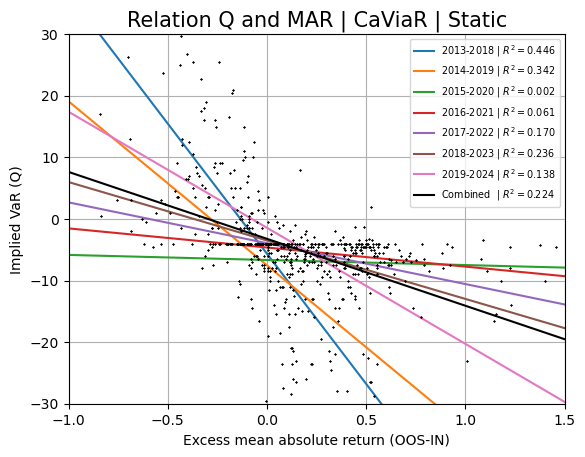

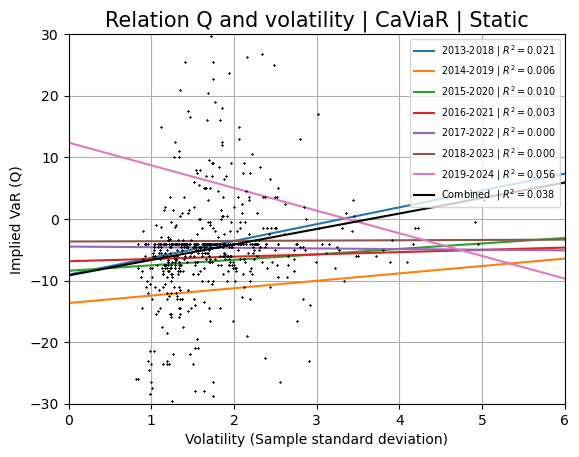

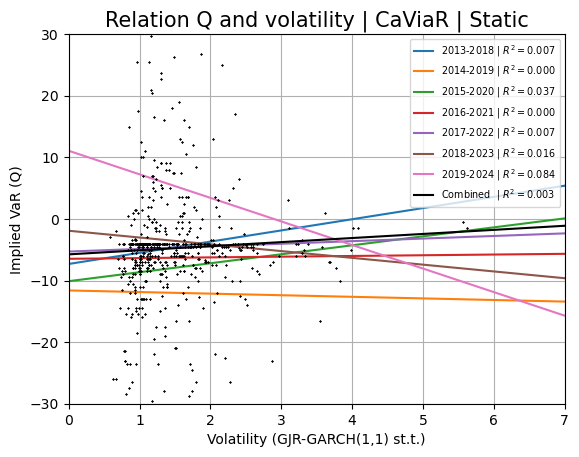

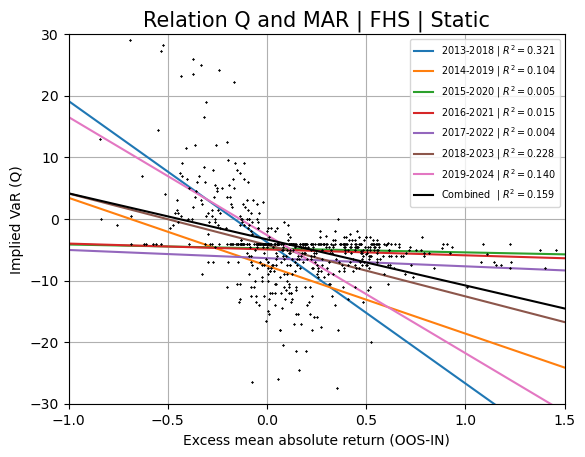

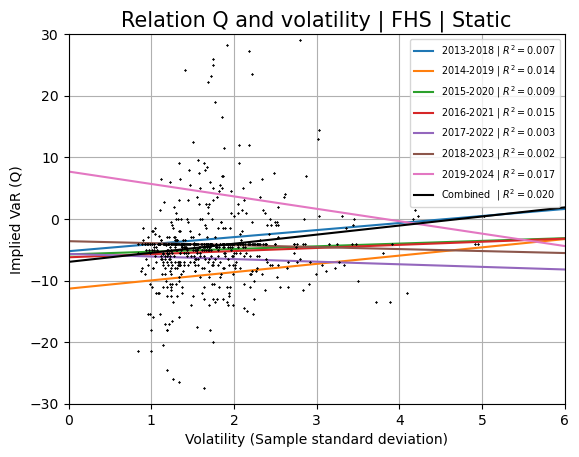

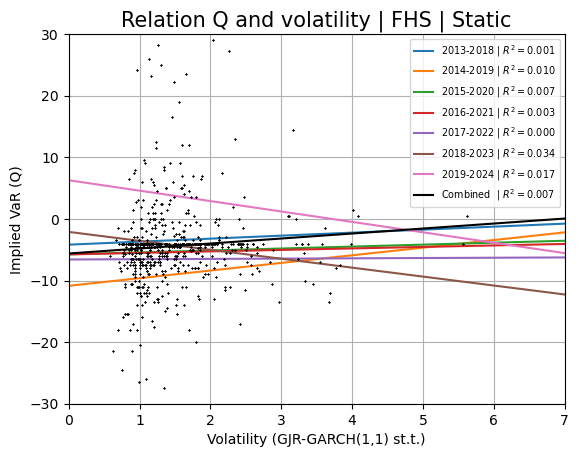

In [ ]:
# Make the plots for CaViaR using the data obtained from the previous cell.
plot_Qplot(plot_dict_CaViaR_MAR, full_excess_CaViaR_MAR, full_Q_CaViaR_MAR, VaR_type="CaViaR", Q_type="MAR", method="Static")
plot_Qplot(plot_dict_CaViaR_STD, full_excess_CaViaR_STD, full_Q_CaViaR_STD, VaR_type="CaViaR", Q_type="STD", method="Static")
plot_Qplot(plot_dict_CaViaR_GAR, full_excess_CaViaR_GAR, full_Q_CaViaR_GAR, VaR_type="CaViaR", Q_type="GARCH", method="Static")

# Make the plots for FHS using the data obtained from the previous cell.
plot_Qplot(plot_dict_FHS_MAR, full_excess_FHS_MAR, full_Q_FHS_MAR, VaR_type="FHS", Q_type="MAR", method="Static")
plot_Qplot(plot_dict_FHS_STD, full_excess_FHS_STD, full_Q_FHS_STD, VaR_type="FHS", Q_type="STD", method="Static")
plot_Qplot(plot_dict_FHS_GAR, full_excess_FHS_GAR, full_Q_FHS_GAR, VaR_type="FHS", Q_type="GARCH", method="Static")

### Dynamic Q plot

In [ ]:
"""
generate_dynamic_dictionary
Function to calculate the dynamic VaR values and return it as a dictionary with keys called "CaViaR2019" or 
"GARCH2020" for example. Then writes the dictionary using Numpy, since it takes a while to compute. Only has to 
be run once. 
"""

# Function to generate the dictionary of dyanmic VaR values. Runtime ~106 minutes.
def generate_dynamic_dictionary():    

    # Define the years of our windows of interest and loop through them.
    window_years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]

    # Read the initial guesses from the csv.
    SP100_guesses_GARCH = pd.read_csv("Data/GARCH_guesses_SP100.csv") 
    SP100_guesses_CaViaR = pd.read_csv("Data/CaViaR_guesses_SP100.csv")

    # Initialize the dictionary.
    filtered_VaR_dict = {}

    # Loop through all the years.
    for year in window_years:
        
        # Obtain the correct stocks and initial guesses. Excluded CVX because of problems with convergence.
        stocks = [col for col in SP100_full_returns.columns if col not in ["date", "CVX"]]
        GARCH_guesses = SP100_guesses_GARCH[SP100_guesses_GARCH["year"] == year].drop(columns=["year"])
        CaViaR_guesses = SP100_guesses_CaViaR[SP100_guesses_CaViaR["year"] == year].drop(columns=["year"])

        # Define the dates which the returns need to be based on.
        start_date = "01-01-" + str(year - 6)
        training_date = "01-01-" + str(year - 2)
        end_date = "01-01-" + str(year)

        # Define the training dataframe and the full dataframe.
        # Full dataframe also includes data used for backtesting.
        SP100_returns = SP100_full_returns[(SP100_full_returns["date"] < end_date) & 
                                            (SP100_full_returns["date"] > start_date)].reset_index(drop=True)
        SP100_training = SP100_returns[(SP100_returns["date"] < training_date)].reset_index(drop=True)
        T = len(SP100_training)
        window_size = len(SP100_returns) - T

        # Obtain the Dynamic VaR using the function.
        GARCH_VaR, FHS_VaR, CaViaR_VaR, POT_VaR, _ = dynamic_VaR(SP100_returns, GARCH_guesses, CaViaR_guesses, window_size, stocks)

        # Print and save all these results to a dictionary.
        print("\nGARCH")
        display(GARCH_VaR)
        filtered_VaR_dict["GARCH"+str(year)] = GARCH_VaR

        print("\nFHS")
        display(FHS_VaR)
        filtered_VaR_dict["FHS"+str(year)] = FHS_VaR

        print("\nCaViaR")
        display(CaViaR_VaR)
        filtered_VaR_dict["CaViaR"+str(year)] = CaViaR_VaR

        print("\nPOT")
        display(POT_VaR)
        filtered_VaR_dict["POT"+str(year)] = POT_VaR

    # Write the dictionary to a file, so we have it for later.
    np.save('Data/Filtered_VaR_dict.npy', filtered_VaR_dict) 

    return filtered_VaR_dict

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     16.38
Date:                 wo, 25 jun 2025   Prob (F-statistic):           0.000121
Time:                        14:31:42   Log-Likelihood:                -246.10
No. Observations:                  80   AIC:                             496.2
Df Residuals:                      78   BIC:                             501.0
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8277      0.577     -8.360      0.0

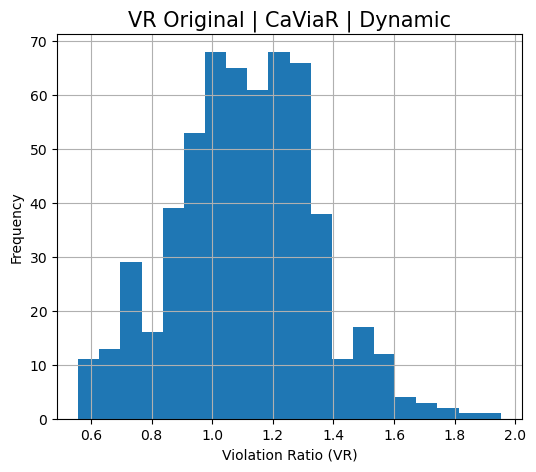

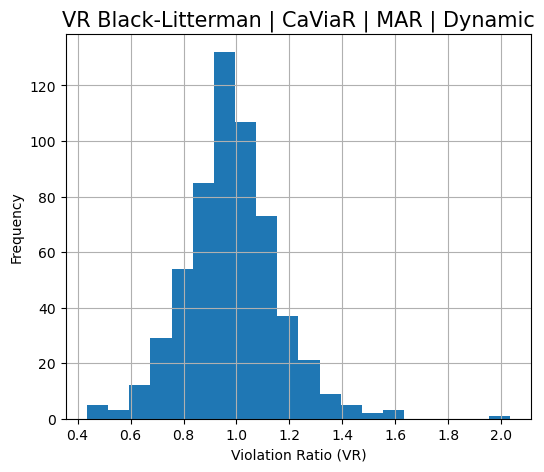

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     90.67
Date:                 wo, 25 jun 2025   Prob (F-statistic):           4.63e-20
Time:                        14:38:30   Log-Likelihood:                -1836.3
No. Observations:                 578   AIC:                             3677.
Df Residuals:                     576   BIC:                             3685.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4230      0.310     -7.813      0.0

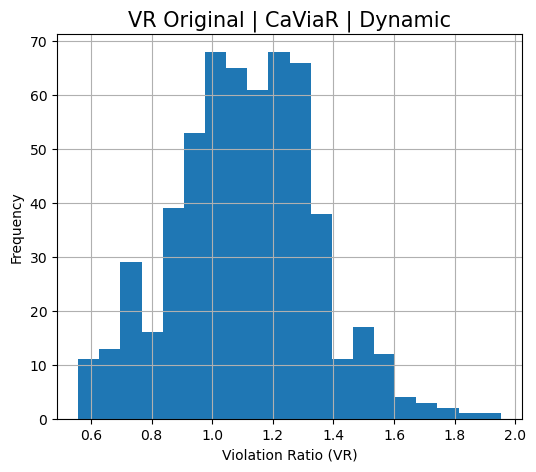

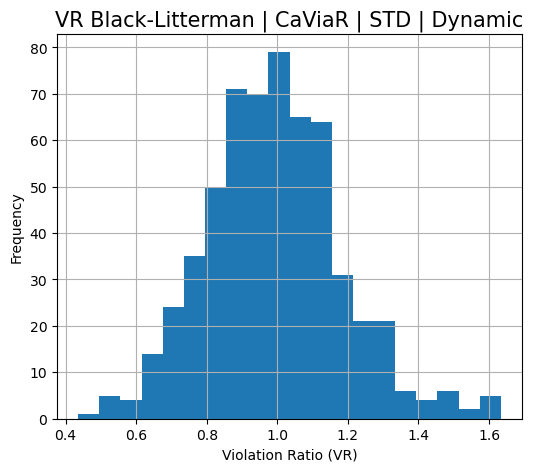

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     20.70
Date:                 wo, 25 jun 2025   Prob (F-statistic):           6.56e-06
Time:                        14:45:59   Log-Likelihood:                -1884.3
No. Observations:                 578   AIC:                             3773.
Df Residuals:                     576   BIC:                             3781.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.3392      0.659     -9.615      0.0

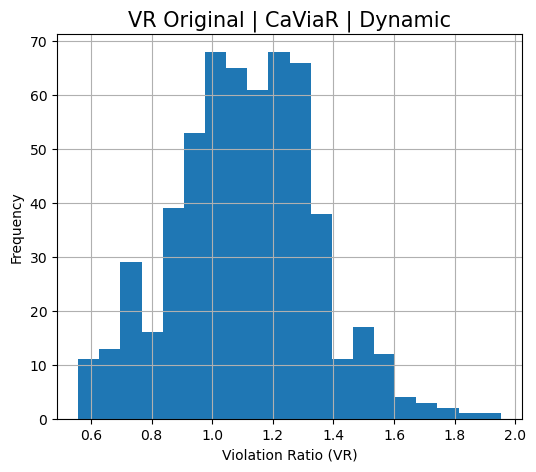

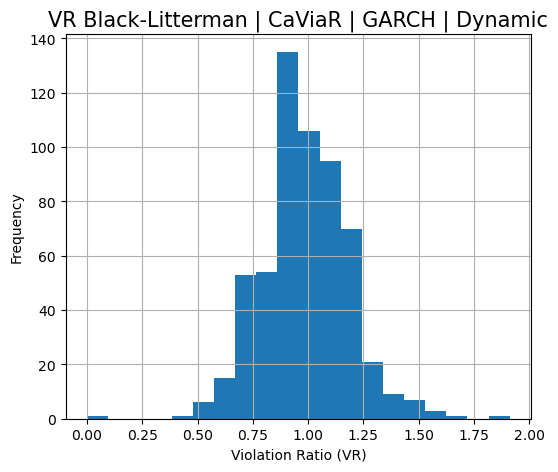

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                     1.414
Date:                 wo, 25 jun 2025   Prob (F-statistic):              0.235
Time:                        14:56:20   Log-Likelihood:                -1889.0
No. Observations:                 577   AIC:                             3782.
Df Residuals:                     575   BIC:                             3791.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0173      0.580     -6.924      0.0

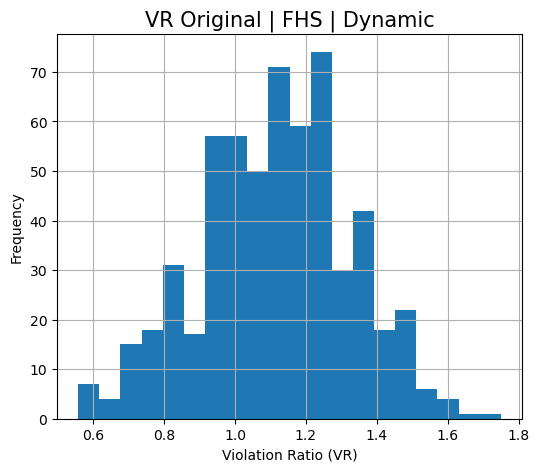

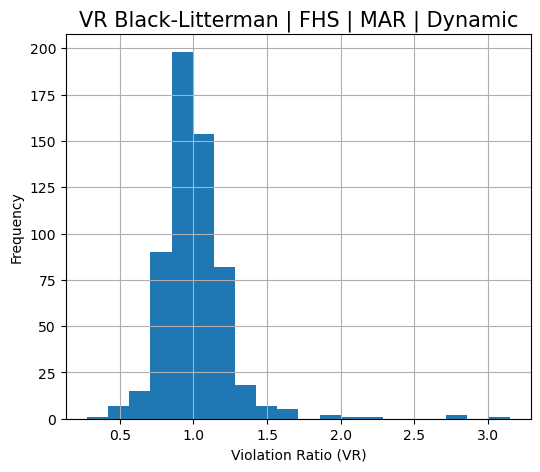

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     53.89
Date:                 wo, 25 jun 2025   Prob (F-statistic):           7.16e-13
Time:                        15:02:30   Log-Likelihood:                -1841.8
No. Observations:                 584   AIC:                             3688.
Df Residuals:                     582   BIC:                             3696.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2116      0.310    -10.374      0.0

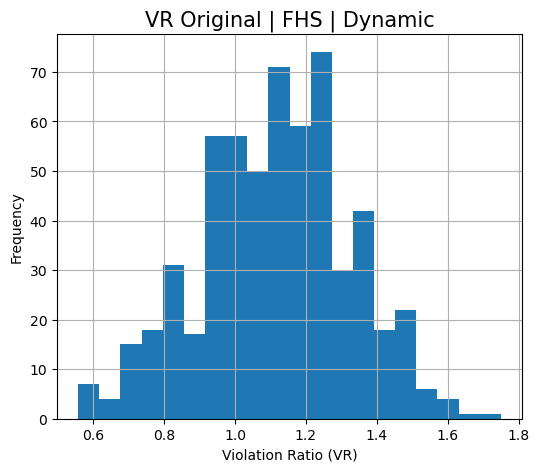

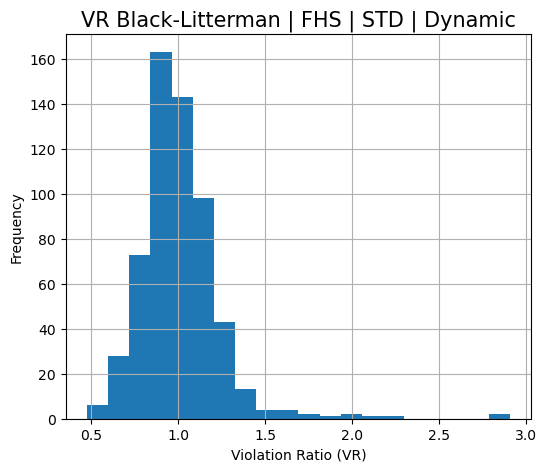

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     18.01
Date:                 wo, 25 jun 2025   Prob (F-statistic):           2.55e-05
Time:                        15:08:42   Log-Likelihood:                -1873.1
No. Observations:                 584   AIC:                             3750.
Df Residuals:                     582   BIC:                             3759.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7917      0.666    -10.204      0.0

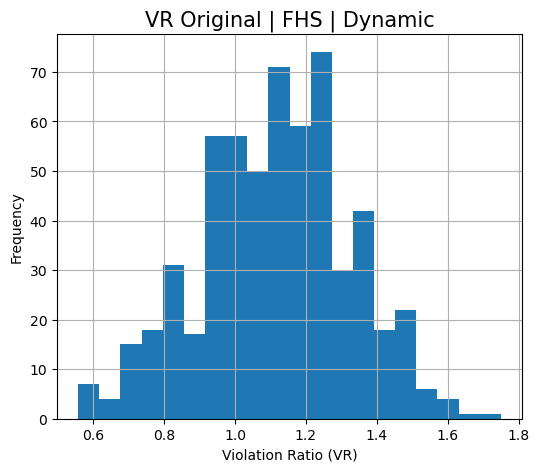

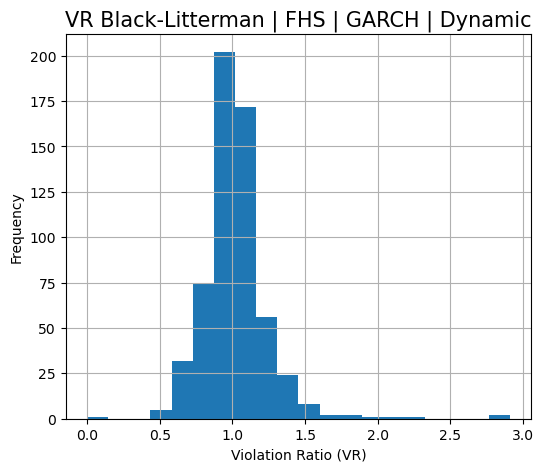

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.947
Date:                 wo, 25 jun 2025   Prob (F-statistic):             0.0150
Time:                        15:16:09   Log-Likelihood:                -1876.6
No. Observations:                 583   AIC:                             3757.
Df Residuals:                     581   BIC:                             3766.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1715      0.566     -9.131      0.0

In [ ]:
"""
generate_dynamic_Q_plot
Takes in the dictionary with the VaR values per year and per model, the type of VaR that is to be considered, the type 
of Q we want to estimate, the method (always dynamic) and the values for tau and Omega. Then it runs through all possible 
combinations of a 4-year training and 2-year testing window, so we have time-varying results and check if the estimates 
are constant over time. It then selectsthe correct training and testing windows and obtains the dynamic VaR values from 
the dictionary. It then calls the BL_VaR_optimize function to obtain the best guesses (implied Q) for Q that give a VR 
of around 1. After that, it calculates the correct value for the x-axis to plot against and run the OLS to obtain the 
parameters. These are then fed into the histogram function as well. Finally, the lines are saved into the dictionary 
to be used in plot_Qplot to make the plots.
"""

# Function to make the plot of the implied VaR vs fraction.
def generate_dynamic_Q_plot(VaR_dict, VaR_type="CaViaR", Q_type="MAR", method="Dynamic", tau=0.075, Omega=1):

    # Define storage for the final regression on all datapoints.
    full_Q = []
    full_excess = []
    BL_list = []
    ORIG_list = []
    plot_dict = {"x_data":[], "y_data":[], "label":[]}

    # Read the initial guesses from the csv.
    SP100_guesses_GARCH = pd.read_csv("Data/GARCH_guesses_SP100.csv") 

    # Define the years of our windows of interest and loop through them.
    window_years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]
    for year in window_years:

        # Extract the correct filtered_VaR.
        filtered_VaR = VaR_dict[VaR_type + str(year)]

        # Obtain the correct stocks and initial guesses.
        stocks = [col for col in SP100_full_returns.columns if col not in ["date", "CVX"]]
        GARCH_guesses = SP100_guesses_GARCH[SP100_guesses_GARCH["year"] == year].drop(columns=["year"])

        # Define the dates which the returns need to be based on.
        start_date = "01-01-" + str(year - 6)
        training_date = "01-01-" + str(year - 2)
        end_date = "01-01-" + str(year)

        # Define the training dataframe and the full dataframe.
        # Full dataframe also includes data used for backtesting.
        SP100_returns = SP100_full_returns[(SP100_full_returns["date"] < end_date) & 
                                           (SP100_full_returns["date"] > start_date)].reset_index(drop=True)
        SP100_training = SP100_returns[(SP100_returns["date"] < training_date)].reset_index(drop=True)
        T = len(SP100_training)
        window_size = len(SP100_returns) - T

        # When using the GARCH Q_type, we need to have the GARCH converged as well. 
        # For that reason, first compute which stocks of the GARCH converge and then continue.
        if Q_type == "GARCH":
            stocks = full_GARCH(SP100_returns, SP100_training, stocks, GARCH_guesses, printing=False)[2]

        # Run these through the Black-Litterman VaR optimizer to get implied values of Q.
        _, implied_Q, limit_exceeded = BL_VaR_optimize(filtered_VaR[-window_size:].reset_index(drop=True), SP100_returns, 1, year, stocks, tau, Omega)

        # Define the stocks that were below threshold and calculate the difference in absolute returns.
        kept_stocks = [stock for stock in stocks if stock not in limit_exceeded]
        kept_Q = [Q for Q in implied_Q if abs(Q) <= threshold_Q]
        
        # Compute the Mean Absolute Return when "MAR" is selected.
        if Q_type == "MAR":
            MAR_IS = np.array(np.abs(SP100_returns[kept_stocks][:T]).mean())
            MAR_OS = np.array(np.abs(SP100_returns[kept_stocks][(T+1):]).mean())
            excess = MAR_OS - MAR_IS

        # Compute the sample standard deviation when "STD" is selected.
        if Q_type == "STD":
            excess = np.array(np.std(SP100_returns[kept_stocks][:T]))

        # Compute the filtered GARCH estimate when "GARCH" is selected.
        elif Q_type == "GARCH":
            print(f"\nFor GARCH in {year}:")
            filtered_GARCH = full_GARCH(SP100_returns, SP100_training, kept_stocks, GARCH_guesses)[0]
            excess = np.array(filtered_GARCH.iloc[T])

        # Add the elements of this year to total list.
        full_Q.extend(kept_Q)
        full_excess.extend(excess)

        # Define the OLS so we can check the relation between Q and excess.
        a, b, x, y, r2 = run_OLS(excess, kept_Q)

        # Make the histogram using the function.
        plotting = True if year == 2025 else False
        BL_list, ORIG_list = make_histogram(filtered_VaR[-window_size:].reset_index(drop=True), SP100_returns, 
                                            a, b, excess, kept_stocks, BL_list, ORIG_list, VaR_type, Q_type, method, plotting)

        # Save the data to plot in the graph.
        label = str(year-6)+"-"+str(year-1)+" | "+r"$R^2 = $"+r2
        plot_dict["x_data"].append(x)
        plot_dict["y_data"].append(y)
        plot_dict["label"].append(label)

    # Define the OLS so we can check the relation between Q and excess.
    a, b, x, y, r2 = run_OLS(full_excess, full_Q)

    # Save the combined data to save in the graph.
    label = "Combined  | "+r"$R^2 = $"+r2
    plot_dict["x_data"].append(x)
    plot_dict["y_data"].append(y)
    plot_dict["label"].append(label)

    return plot_dict, full_excess, full_Q

# Import the dictionary or run the function to obtain the dictionary.
# filtered_VaR_dict = generate_dynamic_dictionary()
filtered_VaR_dict = np.load("Data/Filtered_VaR_dict.npy",allow_pickle="TRUE").item()

# Runtime ~45 minutes with guesses in csv. Be carefull, prints the last OLS output after histogram!
plot_dict_CaViaR_MAR, full_excess_CaViaR_MAR, full_Q_CaViaR_MAR = generate_dynamic_Q_plot(filtered_VaR_dict, VaR_type="CaViaR", Q_type="MAR")
plot_dict_CaViaR_STD, full_excess_CaViaR_STD, full_Q_CaViaR_STD = generate_dynamic_Q_plot(filtered_VaR_dict, VaR_type="CaViaR", Q_type="STD")
plot_dict_CaViaR_GAR, full_excess_CaViaR_GAR, full_Q_CaViaR_GAR = generate_dynamic_Q_plot(filtered_VaR_dict, VaR_type="CaViaR", Q_type="GARCH")

plot_dict_FHS_MAR, full_excess_FHS_MAR, full_Q_FHS_MAR = generate_dynamic_Q_plot(filtered_VaR_dict, VaR_type="FHS", Q_type="MAR")
plot_dict_FHS_STD, full_excess_FHS_STD, full_Q_FHS_STD = generate_dynamic_Q_plot(filtered_VaR_dict, VaR_type="FHS", Q_type="STD")
plot_dict_FHS_GAR, full_excess_FHS_GAR, full_Q_FHS_GAR = generate_dynamic_Q_plot(filtered_VaR_dict, VaR_type="FHS", Q_type="GARCH")

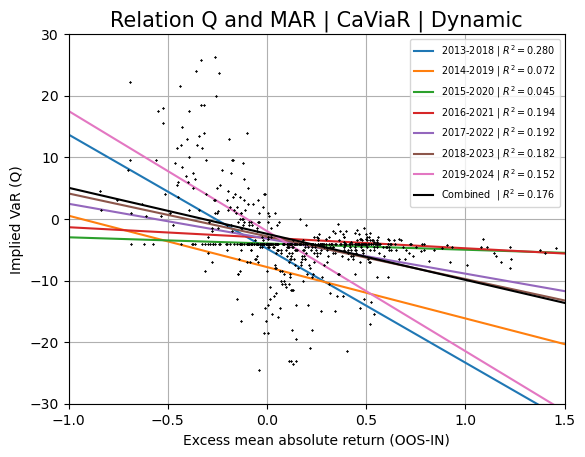

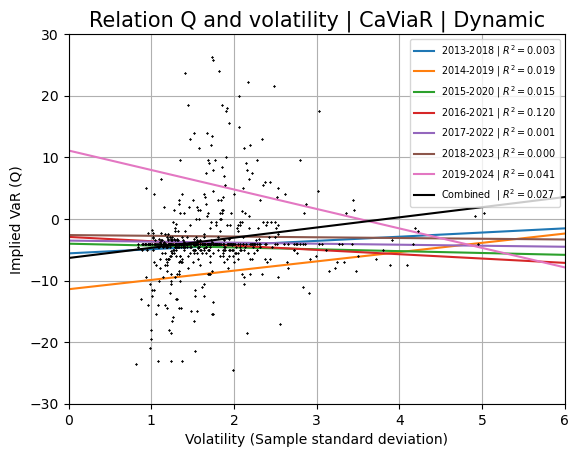

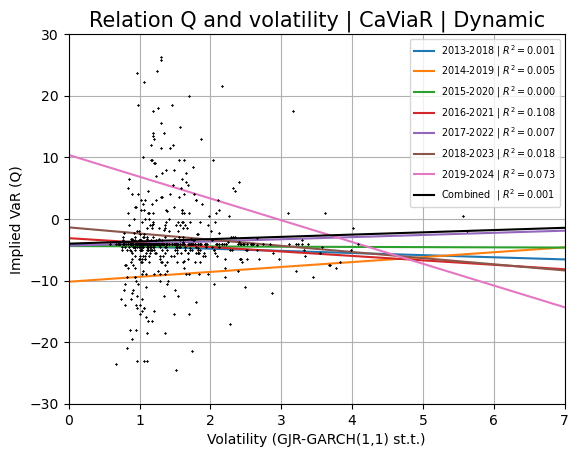

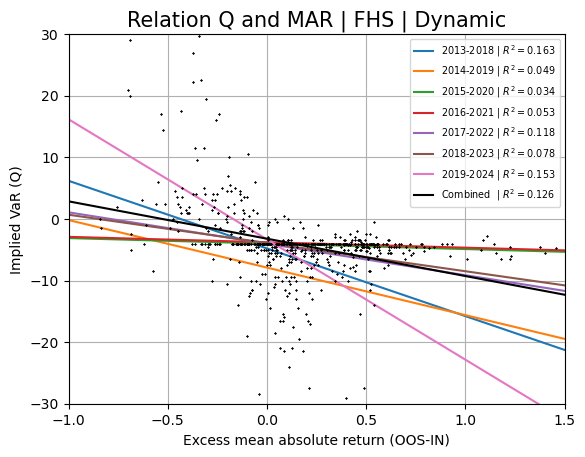

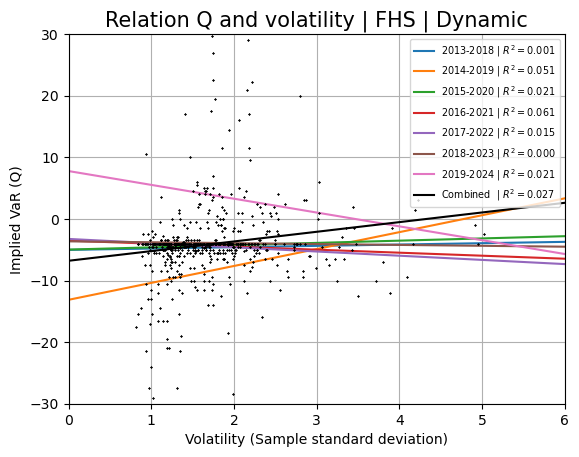

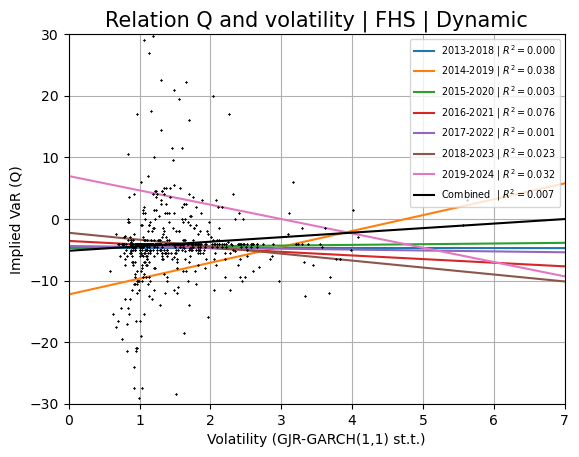

In [ ]:
# Make the plots for CaViaR using the data obtained from the previous cell.
plot_Qplot(plot_dict_CaViaR_MAR, full_excess_CaViaR_MAR, full_Q_CaViaR_MAR, VaR_type="CaViaR", Q_type="MAR", method="Dynamic")
plot_Qplot(plot_dict_CaViaR_STD, full_excess_CaViaR_STD, full_Q_CaViaR_STD, VaR_type="CaViaR", Q_type="STD", method="Dynamic")
plot_Qplot(plot_dict_CaViaR_GAR, full_excess_CaViaR_GAR, full_Q_CaViaR_GAR, VaR_type="CaViaR", Q_type="GARCH", method="Dynamic")

# Make the plots for FHS using the data obtained from the previous cell.
plot_Qplot(plot_dict_FHS_MAR, full_excess_FHS_MAR, full_Q_FHS_MAR, VaR_type="FHS", Q_type="MAR", method="Dynamic")
plot_Qplot(plot_dict_FHS_STD, full_excess_FHS_STD, full_Q_FHS_STD, VaR_type="FHS", Q_type="STD", method="Dynamic")
plot_Qplot(plot_dict_FHS_GAR, full_excess_FHS_GAR, full_Q_FHS_GAR, VaR_type="FHS", Q_type="GARCH", method="Dynamic")

### Predict Q based on MAR

In [ ]:
"""
check_BL
Takes in the regression coefficients from the OLS (obtained from OLS summary in the logs above), the filtered VaR
(either dynamic or static as computed earlier) and the type of VaR (CaViaR or FHS). Then it uses the in-sample
standard deviation of all 9 stocks and the regression output to make an assumption about the best guess Q for the 
Black-Litterman approach of the VaR. In the end, it prints both the test statistics/p-values from the original VaR
and the Black-Litterman approach. This enables us to compare results and say something about the performance.
"""

# Function to run the Black-Litterman check, table for in report.
def check_BL(a, b, filtered_VaR, VaR_type):

    # Loop through the stocks and calculate the expected value of Q based on OLS.
    for stock in stocks:
        IS_std = np.std(returns[stock][:-T])
        Q_predicted = a + IS_std + b
        Q_list.append(Q_predicted)

    # Print the result, comparing original approach to the Black-Litterman.
    print("\n\nFor the regular approach of the "+VaR_type+" model:")
    run_christoffersen(check_violations(filtered_VaR[stocks][-T:], returns[-T:].reset_index(drop=True), pd.DataFrame()), quantile)

    print("\nFor the Black-Litterman approach of the "+VaR_type+" model:")
    BL_CaViaR_uni = BL_VaR_single(filtered_VaR[stocks][-T:], window_size, Q_list, weight_type="equal")[1]
    run_christoffersen(check_violations(BL_CaViaR_uni[stocks], returns[-(T-window_size):].reset_index(drop=True), pd.DataFrame()), quantile)

# Define some variables.
T = len(CaViaR_VaR)
window_size = 1
stocks = ["AAPL", "AMZN", "AVGO", "JPM", "META", "MSFT", "NVDA", "TSLA", "V"]

# Define the variables to test the theory.
Q_list = []

# Static CaViaR
check_BL(2.5110103064119857, -9.166866273930395, oos_filtered_CaViaR, "CaViaR")   

# Static FHS
check_BL(1.4737222203348694, -6.972343290730636, oos_FHS, "FHS") 

# Dynamic CaViaR
check_BL(1.6489985983177826, -6.339171787151946, CaViaR_VaR, "CaViaR") 

# Dynamic FHS 
check_BL(1.5675804586734832, -6.7917001386002696, FHS_VaR, "FHS") 



For the regular approach of the CaViaR model:
& \textbf{AAPL} & 0.217 & 0.367 & 0.311 & 1.180\\
& \textbf{AMZN} & \textbf{0.021} & \textbf{0.037} & \textbf{0.008} & 1.340\\
& \textbf{AVGO} & 0.170 & 0.104 & 0.104 & 1.200\\
& \textbf{JPM} & 0.413 & 0.940 & 0.714 & 1.120\\
& \textbf{META} & 0.413 & 0.143 & 0.245 & 1.120\\
& \textbf{MSFT} & \textbf{0.041} & 0.056 & \textbf{0.020} & 1.300\\
& \textbf{NVDA} & 0.273 & 0.115 & 0.158 & 1.160\\
& \textbf{TSLA} & 0.132 & 0.306 & 0.190 & 1.220\\
& \textbf{V} & 0.971 & 0.736 & 0.944 & 1.000\\

For the Black-Litterman approach of the CaViaR model:
& \textbf{AAPL} & 0.795 & 0.641 & 0.867 & 1.040\\
& \textbf{AMZN} & 0.409 & 0.143 & 0.243 & 1.120\\
& \textbf{AVGO} & 0.409 & 0.143 & 0.243 & 1.120\\
& \textbf{JPM} & 0.862 & 0.289 & 0.561 & 0.980\\
& \textbf{META} & 0.587 & 0.177 & 0.346 & 1.080\\
& \textbf{MSFT} & 0.688 & \textbf{0.015} & \textbf{0.048} & 1.060\\
& \textbf{NVDA} & 0.214 & 0.366 & 0.308 & 1.180\\
& \textbf{TSLA} & \textbf{0.007} & 0.32

### Test different values of tau and Omega

In [ ]:
# # Run the static 7 times with different tau and Omega for CaViaR. Runtime ~70minutes
# # Function with 0.075 and 1 as final one, since then it saves the histograms correctly.
# # This last one is placed in front of the table in the report, so be careful!
# generate_static_Q_plot(VaR_type="CaViaR", Q_type="STD", tau=0.050, Omega=1)
# generate_static_Q_plot(VaR_type="CaViaR", Q_type="STD", tau=0.100, Omega=1)
# generate_static_Q_plot(VaR_type="CaViaR", Q_type="STD", tau=0.075, Omega=0.5)
# generate_static_Q_plot(VaR_type="CaViaR", Q_type="STD", tau=0.075, Omega=2)
# generate_static_Q_plot(VaR_type="CaViaR", Q_type="STD", tau=0.050, Omega=2)
# generate_static_Q_plot(VaR_type="CaViaR", Q_type="STD", tau=0.100, Omega=0.5)
# generate_static_Q_plot(VaR_type="CaViaR", Q_type="STD", tau=0.075, Omega=1)